In [1]:
# %% init
import os
os.chdir("/home/tangir/crmbm/python/pastis")

from IPython import get_ipython
get_ipython().magic("clear")

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import mrs.reco as reco
import mrs.sim as sim
import mrs.db as db
import mrs.log as log
import mrs.aliases as xxx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import suspect
from datetime import datetime

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
# get_ipython().magic("matplotlib inline")
get_ipython().magic("matplotlib notebook")
log.setLevel(log.INFO)

cm = sns.color_palette("rocket", as_cmap=True)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

(DEBUG) Loaded backend nbAgg version unknown.


# Load dataframes from files

In [2]:
df_sc = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_notebook.pkl")
df_sc_no_dr = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_nodr_notebook.pkl")
df_sc_no_dr_no_rea = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_nodr_norea_notebook.pkl")

df_brain = pd.read_pickle("/home/tangir/crmbm/acq_db/brain_notebook.pkl")

# Prepare dataframes
Anything below deals with fit results

## Load fit data

In [3]:
rdb = db.data_db("/home/tangir/crmbm/acq_db/sc.pkl")
df_sc_fit = rdb.extend_df_fit()
del(rdb)

rdb = db.data_db("/home/tangir/crmbm/acq_db/sc_nodr.pkl")
df_sc_no_dr_fit = rdb.extend_df_fit()
del(rdb)

rdb = db.data_db("/home/tangir/crmbm/acq_db/sc_nodr_norea.pkl")
df_sc_no_dr_no_rea_fit = rdb.extend_df_fit()
del(rdb)

rdb = db.data_db("/home/tangir/crmbm/acq_db/brain.pkl")
df_brain_fit = rdb.extend_df_fit()
del(rdb)

(INFO)  data_db.__init__: initializing db files [in progress]
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/sc.pkl
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/sc_fit.pkl
(INFO)  data_db.read_pickle_files: reading storage file [done]...
(INFO)  data_db.read_pickle_files: reading storage file [/home/tangir/crmbm/acq_db/sc_fit.pkl]...
(INFO)  data_db.read_pickle_files: reading storage file [done]...
(INFO)  data_db.__init__: initializing db files [done]
(INFO)  data_db.extend_df_fit: extending dataframe by scraping data...
(INFO)  data_db.__init__: initializing db files [in progress]
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/sc_nodr.pkl
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/sc_nodr_fit.pkl
(INFO)  data_db.read_pickle_files: reading storage file [done]...
(INFO)  data_db.read_pickle_files: reading storage file [/home/tangir/crmbm/acq_db/sc_nodr_fit.pkl]...
(INFO)  data_db.read_pickle_files: reading storage file [done]...
(INFO)  data_db.__init__: initi

## Join data

In [4]:
# SC dataframe
df_sc = pd.merge(df_sc_fit, df_sc, left_on='scan_hash', right_index=True, how='inner', sort=False)
df_sc_no_dr = pd.merge(df_sc_no_dr_fit, df_sc_no_dr, left_on='scan_hash', right_index=True, how='inner', sort=False)
df_sc_no_dr_no_rea = pd.merge(df_sc_no_dr_no_rea_fit, df_sc_no_dr_no_rea, left_on='scan_hash', right_index=True, how='inner', sort=False)

# brain dataframe
df_brain = pd.merge(df_brain_fit, df_brain, left_on='scan_hash', right_index=True, how='inner', sort=False)

## Show really badly fitted SC datasets
using FQN and R2, just to check things and reco/refit if necessary

In [5]:
df = df_sc

rsq_f_threshold = 0.6
fqn_threshold = 3

df_bad_fit = df.loc[(df["fit_results_optim_result_rsq_f"] < rsq_f_threshold)
                    & (df["fit_results_optim_result_fqn"] > fqn_threshold)]

k = 0
for this_index, this_row in df_bad_fit.iterrows():
    s = this_row["dataset_raw_data_obj"]
    if(s is None):
        s = this_row["dataset_dcm_data_obj"]
    
    s.set_display_offset(20000.0 * k)
    s.display_spectrum_1d(3303)
    k += 1
    
df_bad_fit[["patient", "study", "scan_hash", "fit_strategy_name", "dataset_legend", "dataset_raw_analysis-results_cropping_snr", "dataset_raw_analysis-results_cropping_lw"]]

Empty DataFrame
Columns: [patient, study, scan_hash, fit_strategy_name, dataset_legend, dataset_raw_analysis-results_cropping_snr, dataset_raw_analysis-results_cropping_lw]
Index: []

Only three datasets are really badly fitted - whatever the fit strategy used. Let's see how they annoy us for the following... 

## Recalculate metabolite parameters
* T2/T1 normalization
* ratios
* absolute concentrations
* relative CRBs

In [6]:
water_concentration = 55000.0

def add_metabolite_concentration_columns(this_df, water_c):
    # init new columns
    some_init_col = this_df["fit_results_params_ref_area_pnorm_obj"]
    
    this_df["params_area_pnorm_T2norm_obj"] = some_init_col
    this_df["params_ref_area_pnorm_T2norm_obj"] = some_init_col
    this_df["params_area_pnorm_T2norm_abs_obj"] = some_init_col
    this_df["params_area_pnorm_T2norm_ratio_cre_obj"] = some_init_col

    this_df["params_fit_obj"] = some_init_col
    this_df["params_fit_T2norm_obj"] = some_init_col
    this_df["params_ref_fit_T2norm_obj"] = some_init_col
    this_df["params_fit_T2norm_abs_obj"] = some_init_col
    this_df["params_fit_T2norm_ratio_cre_obj"] = some_init_col

    for this_index, this_row in this_df.iterrows():
        # get params for this row
        p_area = this_row["fit_results_params_area_pnorm_obj"]
        p_ref_area = this_row["fit_results_params_ref_area_pnorm_obj"]
        p_fit = this_row["fit_results_params_fit_final_obj"]
        p_ref_fit = this_row["fit_results_params_ref_fit_obj"]

        # normalize T2
        this_te = this_row["dataset_raw_data__te"]
        p_area_T2norm = p_area.correct_T2s(this_te)
        p_ref_area_T2norm = p_ref_area.correct_T2s(this_te)
        #
        p_fit_T2norm = p_fit.correct_T2s(this_te)
        p_ref_fit_T2norm = p_ref_fit.correct_T2s(this_te)

        # relative to water
        p_area_T2norm_rel_water = p_area_T2norm.get_relative_to_meta(xxx.m_Water, water_c, p_ref_area_T2norm)
        #
        p_fit_T2norm_rel_water = p_fit_T2norm.get_relative_to_meta(xxx.m_Water, water_c, p_ref_fit_T2norm)

        # ratios relative to cr
        p_area_T2norm_ratio_cr = p_area_T2norm.get_ratios(xxx.m_Cr_CH3)
        #
        p_fit_T2norm_ratio_cr = p_fit_T2norm.get_ratios(xxx.m_Cr_CH3)

        # store
        this_df.at[this_index, "params_area_pnorm_T2norm_obj"] = p_area_T2norm
        this_df.at[this_index, "params_ref_area_pnorm_T2norm_obj"] = p_ref_area_T2norm
        this_df.at[this_index, "params_area_pnorm_T2norm_abs_obj"] = p_area_T2norm_rel_water
        this_df.at[this_index, "params_area_pnorm_T2norm_ratio_cre_obj"] = p_area_T2norm_ratio_cr

        this_df.at[this_index, "params_fit_obj"] = p_fit
        this_df.at[this_index, "params_fit_T2norm_obj"] = p_fit_T2norm
        this_df.at[this_index, "params_ref_fit_T2norm_obj"] = p_ref_fit_T2norm
        this_df.at[this_index, "params_fit_T2norm_abs_obj"] = p_fit_T2norm_rel_water
        this_df.at[this_index, "params_fit_T2norm_ratio_cre_obj"] = p_fit_T2norm_ratio_cr
        
    return(this_df)

df_sc = add_metabolite_concentration_columns(df_sc, water_concentration)
df_sc_no_dr = add_metabolite_concentration_columns(df_sc_no_dr, water_concentration)
df_sc_no_dr_no_rea = add_metabolite_concentration_columns(df_sc_no_dr_no_rea, water_concentration)

df_brain = add_metabolite_concentration_columns(df_brain, water_concentration)   

/home/tangir/data/work/recherche/crmbm/python/pastis/mrs/sim.py:189: RuntimeWarning: invalid value encountered in true_divide
  errors_prct = self.errors / self[:] * 100.0
/home/tangir/data/work/recherche/crmbm/python/pastis/mrs/sim.py:476: RuntimeWarning: invalid value encountered in sqrt
  rel_CRBs_ratio = np.sqrt( relCRBs_num**2 + relCRBs_den**2 - 2 * rc_num_den_abs * relCRBs_num * relCRBs_den )


# Break params objects into mutiple columns

In [7]:
def break_params_into_columns(this_df, col_name_list, col_name_list_to_keep):
    
    # make a unique list of metabolites studied, considering all strategies
    metabolite_fit_indexes_list = []
    for sf in this_df["fit_strategy_obj"].unique():
        metabolite_fit_indexes_list = metabolite_fit_indexes_list + list(sf.metabolites)
    metabolite_fit_indexes_list = np.unique(metabolite_fit_indexes_list)

    par_name_list = ["cm", "dd", "df", "dp"]
    this_meta_names_old = None

    for c in col_name_list:
        # browse df and affect columns
        for this_index, this_row in this_df.iterrows():
            # get params for this row
            this_p = this_row[c]
            this_meta_names = this_p.get_meta_names()
            
            # checking consistency btw
            if(this_meta_names_old is not None and this_meta_names != this_meta_names_old):
                log.error("weird stuff here!")
            this_meta_names_old = this_meta_names

            # affect each meta/par/err col
            for im, m in enumerate(this_meta_names):
                if(im in metabolite_fit_indexes_list):
                    for ip, p in enumerate([par_name_list[0]]): # only cm parameters to save RAM
                        # value
                        new_col_name = c + "$" + m + "$" + p + "$val"
                        this_df.at[this_index, new_col_name] = this_p[im, ip]
                        # error
                        new_col_name = c + "$" + m + "$" + p + "$err"
                        this_df.at[this_index, new_col_name] = this_p.errors[im, ip]
                        # error prct
                        new_col_name = c + "$" + m + "$" + p + "$err_prct"
                        this_df.at[this_index, new_col_name] = this_p.get_errors_prct()[im, ip]
                        
    # now remove any sim.params columns to free memory...
    for c in this_df.columns:
        if( (type(this_df[c][0]) == sim.params) & (c not in col_name_list_to_keep) ):
            this_df = this_df.drop(c, axis=1)
    
    return(this_df)


params_cols_to_break = [
                    #"params_area_pnorm_T2norm_obj",
                    #"params_ref_area_pnorm_T2norm_obj",
                    "params_area_pnorm_T2norm_abs_obj",
                    "params_area_pnorm_T2norm_ratio_cre_obj",
                    "params_fit_obj",
                    "params_fit_T2norm_obj",
                    #"params_ref_fit_T2norm_obj",
                    "params_fit_T2norm_abs_obj",
                    "params_fit_T2norm_ratio_cre_obj"
]

params_cols_to_keep = [
                    "params_fit_obj"
]

df_sc = break_params_into_columns(df_sc, params_cols_to_break, params_cols_to_keep)
df_sc_no_dr = break_params_into_columns(df_sc_no_dr, params_cols_to_break, params_cols_to_keep)
df_sc_no_dr_no_rea = break_params_into_columns(df_sc_no_dr_no_rea, params_cols_to_break, params_cols_to_keep)

df_brain = break_params_into_columns(df_brain, params_cols_to_break, params_cols_to_keep)

# Correlation matrix analysis
In case I missed something interesting!

## Generate a correlation matrix of all parameters
To find any correlations between any parameters

In [8]:
def list_highest_corr(this_df_corr, column_name):

    this_df_corr2 = this_df_corr[column_name]
    this_df_corr2 = this_df_corr2.loc[this_df_corr2.abs() < (1.00 - 1e-6)]
    this_df_corr2 = this_df_corr2.loc[this_df_corr2.abs() > 0.5]
    this_df_corr2 = this_df_corr2.iloc[(-this_df_corr2.abs()).argsort()]
    return(this_df_corr2)

df = df_sc
# correlate only numeric fields
df_num = df.select_dtypes(include=np.number)   
df_corr = df_num.corr(min_periods=5)
#pd.set_option('display.max_rows', 500)


In [9]:
this_df_corr = list_highest_corr(df_corr, "dataset_snr_final")
this_df_corr

dataset_raw_analysis-results_averaging_snr                0.998174
dataset_raw_analysis-results_data rejecting_snr           0.998174
dataset_postrej_snr2                                      0.998174
dataset_raw_analysis-results_frequency shifting_snr       0.998130
dataset_postrea_snr                                       0.990473
                                                            ...   
dataset_raw_analysis-results_channel-combining_lw        -0.505948
dataset_raw_analysis-results_estimating noise level_lw   -0.505948
dataset_raw_analysis-results_phasing_lw                  -0.505948
dataset_raw_analysis-results_zero-filling_lw             -0.505948
dataset_dcm_analysis-results_cropping_lw                 -0.504929
Name: dataset_snr_final, Length: 148, dtype: float64

In [10]:
this_df_corr = list_highest_corr(df_corr, "dataset_patient_bmi")
this_df_corr

dataset_raw_data__data_rejection[0]_Rejected spectrum_data_ref__patient_weight                           0.884094
reco_pipeline_dataset[0]_raw_data__data_rejection[0]_Rejected spectrum_data_ref__patient_weight          0.884094
reco_pipeline_dataset[0]_raw_data__data_rejection[0]_Rejected spectrum__patient_weight                   0.884094
dataset_raw_data__data_rejection[0]_Rejected spectrum__patient_weight                                    0.884094
dataset_dcm_data_data_ref__patient_weight                                                                0.884094
                                                                                                           ...   
reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejected spectrum_data_ref__sequence_pulse_rfc_n   -0.503153
reco_pipeline_dataset[1]_raw_data_data_ref__sequence_pulse_rfc_n                                        -0.503153
reco_pipeline_dataset[1]_dcm_data_data_ref__sequence_pulse_rfc_n                        

In [11]:
this_df_corr = list_highest_corr(df_corr, "dataset_lw")
this_df_corr

reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]       -0.999627
reco_pipeline_dataset[1]_raw_analysis-results_cropping_lw                                      0.993704
reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)   -0.992678
reco_pipeline_dataset[1]_raw_analysis-results_data rejecting_lw                                0.991260
reco_pipeline_dataset[1]_raw_analysis-results_averaging_lw                                     0.991260
                                                                                                 ...   
reco_pipeline_dataset[1]_dcm_data_data_ref__sequence_shims[1]                                  0.503657
reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejected spectrum__sequence_shims[1]      0.503657
reco_pipeline_dataset[1]_raw_data__sequence_shims[1]                                           0.503657
reco_pipeline_dataset[1]_raw_data_data_ref__sequence_shims[1]   

In [12]:
this_df_corr = list_highest_corr(df_corr, "dataset_raw_data__sequence_vref")
this_df_corr

reco_pipeline_dataset[1]_raw_data_data_ref__sequence_pulse_exc_duration                                         0.981204
reco_pipeline_dataset[1]_raw_data__sequence_pulse_exc_duration                                                  0.981204
reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejected spectrum_data_ref__sequence_pulse_exc_duration    0.981204
reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejected spectrum__sequence_pulse_exc_duration             0.981204
reco_pipeline_dataset[1]_dcm_data_data_ref__sequence_pulse_exc_duration                                         0.981204
                                                                                                                  ...   
reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejected spectrum_data_ref__patient_height                 0.504201
reco_pipeline_dataset[1]_dcm_data__patient_height                                                               0.504201
reco_pipeline_dataset[1]_raw_dat

In [13]:
this_df_corr = list_highest_corr(df_corr, "dataset_raw_data__sequence_te")
this_df_corr

reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)    0.999589
dataset_raw_data_data_ref__te                                                                  0.874396
dataset_raw_data_data_ref__sequence_te                                                         0.874396
dataset_raw_data__data_rejection[0]_Rejected spectrum_data_ref__te                             0.874396
dataset_raw_data__data_rejection[0]_Rejected spectrum_data_ref__sequence_te                    0.874396
                                                                                                 ...   
reco_pipeline_dataset[1]_dcm_data__noise_level                                                -0.519300
params_fit_T2norm_abs_obj$NAA_CH2$cm$err_prct                                                  0.516477
reco_pipeline_dataset[1]_raw_analysis-results_channel-combining_snr                            0.502602
reco_pipeline_dataset[1]_raw_analysis-results_zero-filling_snr  

In [14]:
this_df_corr = list_highest_corr(df_corr, "params_fit_T2norm_ratio_cre_obj$NAA_CH3$cm$err_prct")
this_df_corr

reco_pipeline_dataset[1]_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)   -0.974671
params_fit_T2norm_obj$NAA_CH3$cm$err_prct                                              0.924726
params_fit_obj$NAA_CH3$cm$err_prct                                                     0.924726
reco_pipeline_dataset[0]_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)    0.839721
dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)                     0.839721
                                                                                         ...   
reco_pipeline_dataset[0]_raw_analysis-results_cropping_snr                            -0.503607
dataset_dcm_analysis-results_data rejecting_snr                                       -0.502420
dataset_dcm_analysis-results_frequency realigning_snr                                 -0.502420
dataset_dcm_analysis-results_apodizing_snr                                            -0.502420
dataset_dcm_analysis-results_averaging_s

In [15]:
#pd.set_option('display.max_rows', 50)

## Plot manually some findings
Choose from the following, according to correlation coeff:
* Could not find any interesting corr for SNR except with other snr estimations, fit criterias and data rejection bounds, shim 7
* BMI and BFP are connected to data rejection (chemical shift, phase bounds), effective acq time, vref, tr, exc pulse durations, f0
* LW maybe connected to noise level, phase rejection bound, shim3, shim6, weight, voi size, shim1, tr, f0, heart, height, pulse dur, vref, r, n
* Vref connected to tr, pulse dur, posY, patient weight/height
* TE is linked to pulse dur, n
* FQN, RSQs are linked to rejection bounds, snr, vref

with a R threshold of 0.5

p1 = dataset_snr_final | p2 = reco_pipeline_dataset[1]_raw_data__sequence_shims[7]


<IPython.core.display.Javascript object>


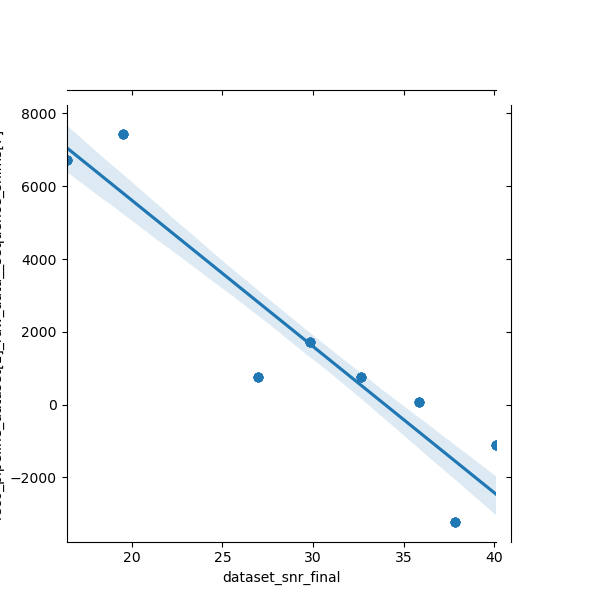

R = -0.93
p1 = dataset_snr_final | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)


<IPython.core.display.Javascript object>


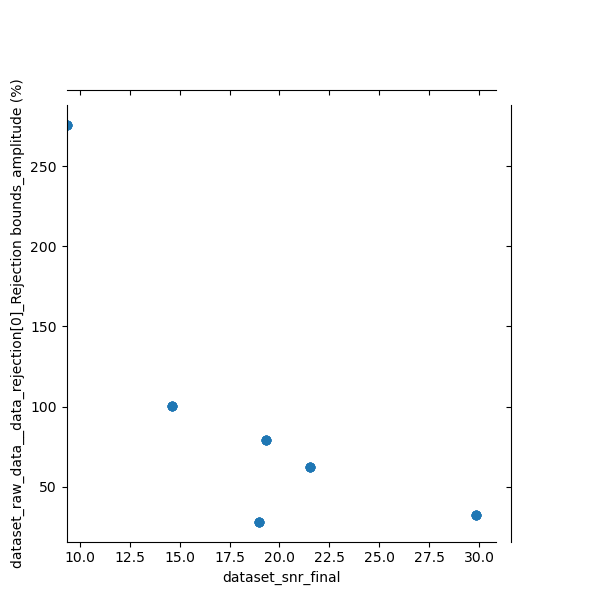

R = nan
p1 = dataset_snr_final | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<IPython.core.display.Javascript object>


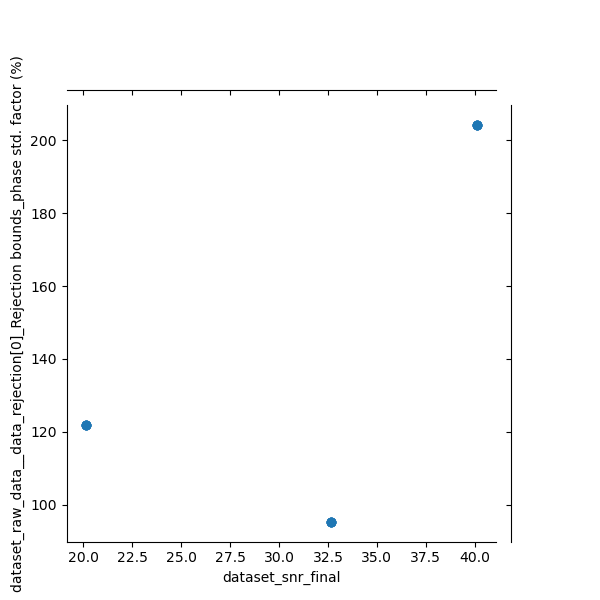

R = nan
p1 = dataset_patient_bmi | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<IPython.core.display.Javascript object>


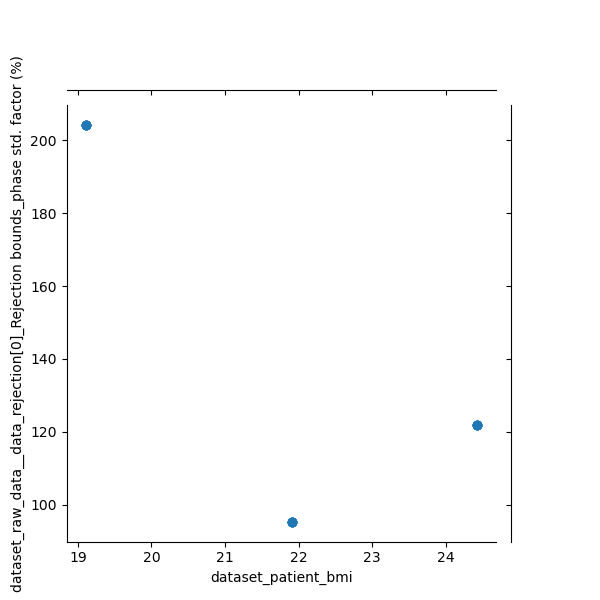

R = nan
p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_vref


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<IPython.core.display.Javascript object>


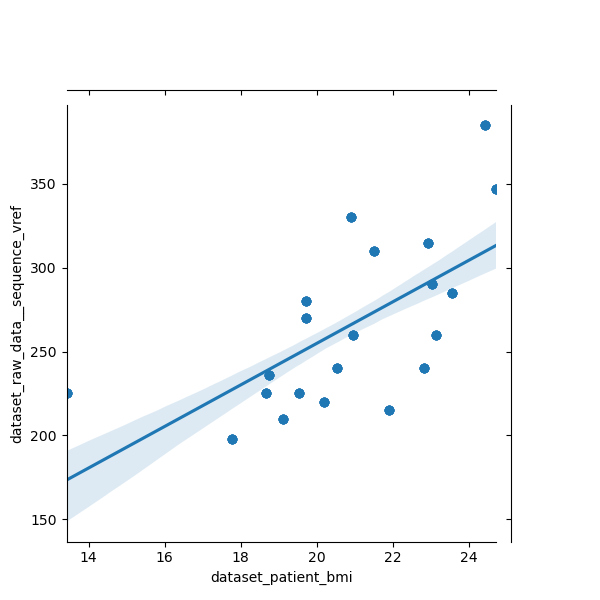

R = 0.65
p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_tr


<IPython.core.display.Javascript object>


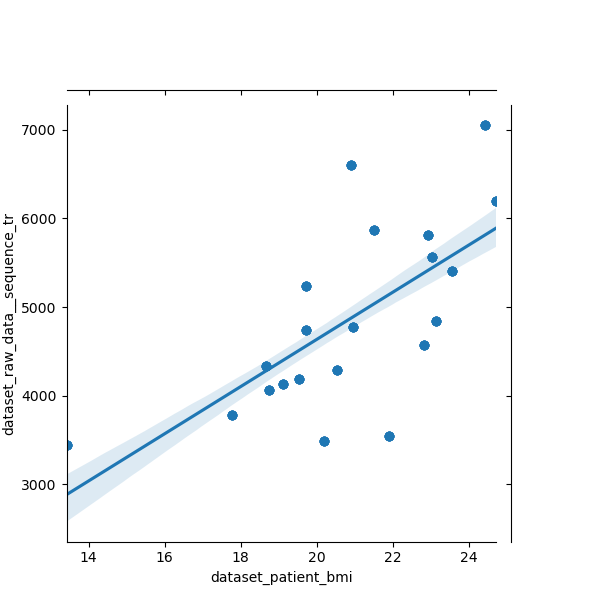

R = 0.67
p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_shims[4]


<IPython.core.display.Javascript object>


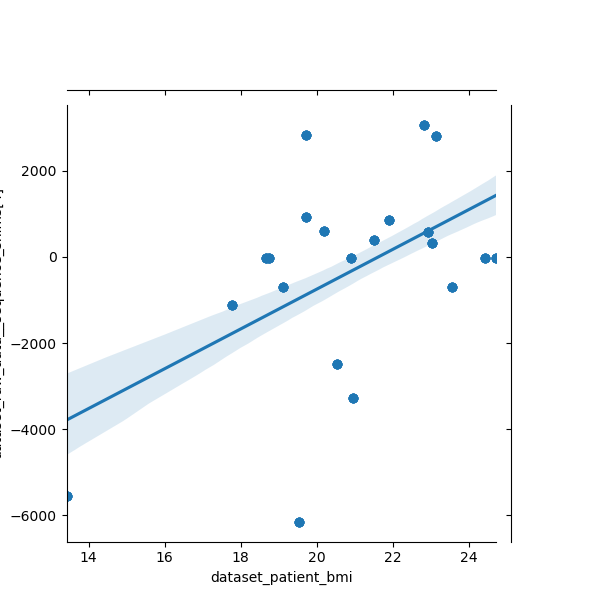

R = 0.51
p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_pulse_exc_duration


<IPython.core.display.Javascript object>


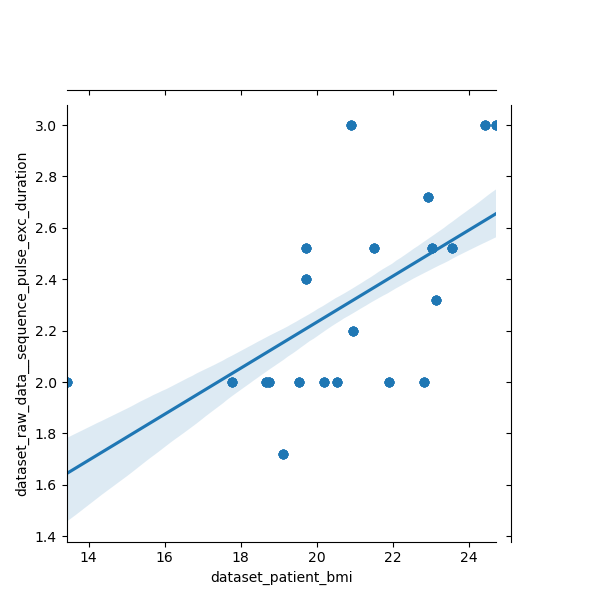

R = 0.60
p1 = dataset_lw | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)


<IPython.core.display.Javascript object>


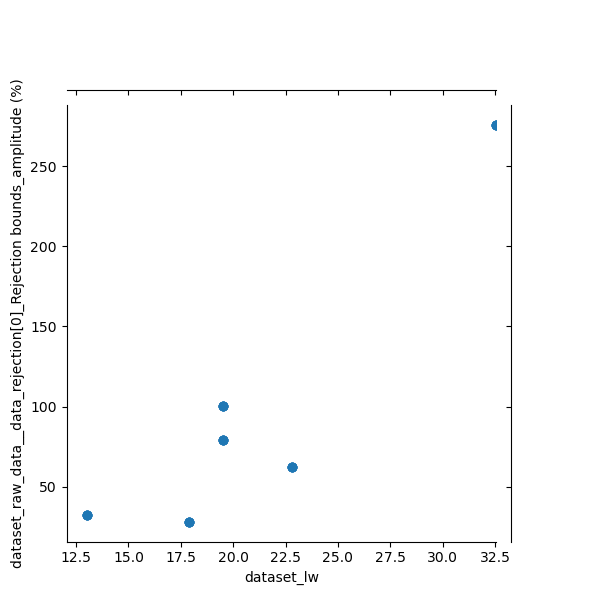

R = nan
p1 = dataset_lw | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<IPython.core.display.Javascript object>


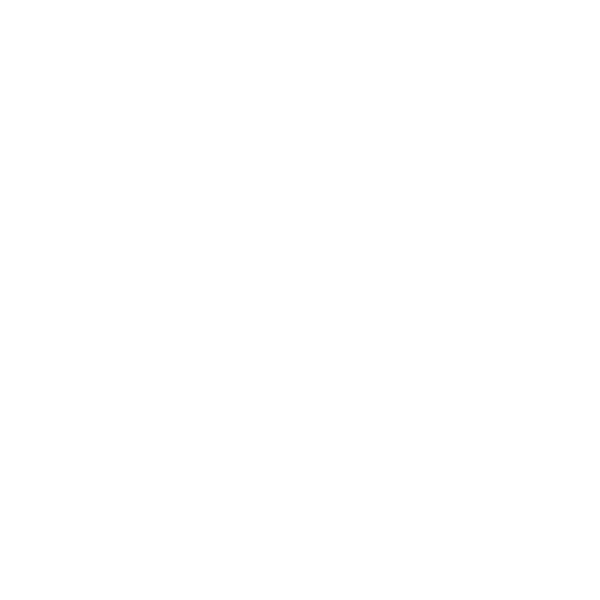

R = nan
p1 = dataset_lw | p2 = params_fit_obj$NAA_CH3$cm$err_prct


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<IPython.core.display.Javascript object>


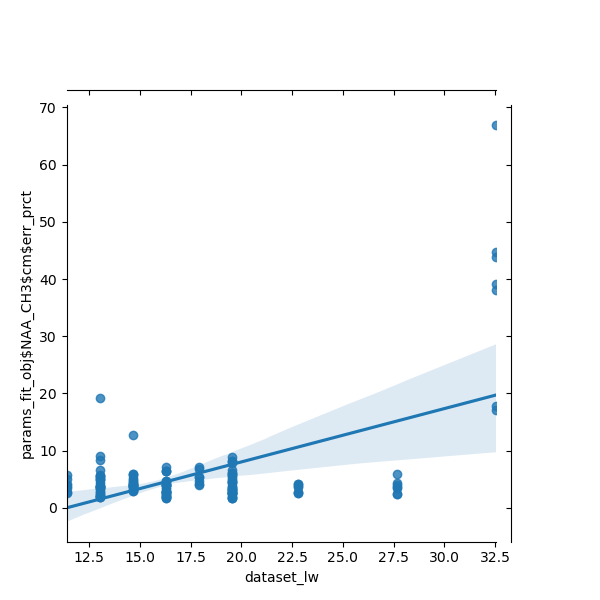

R = 0.56
p1 = dataset_lw | p2 = dataset_prerej_linewidth_mean


<IPython.core.display.Javascript object>


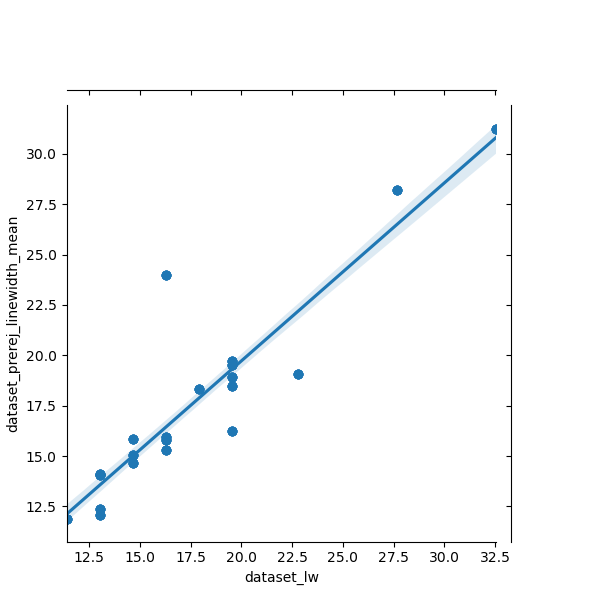

R = 0.91
p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__sequence_tr


<IPython.core.display.Javascript object>


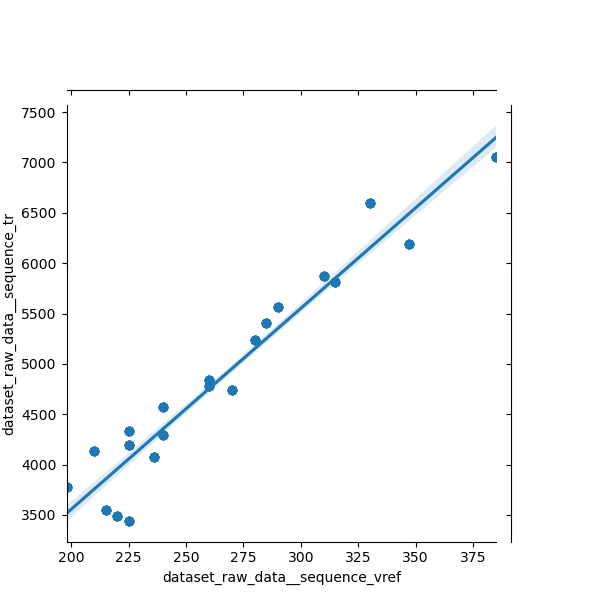

R = 0.96
p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__patient_weight


<IPython.core.display.Javascript object>


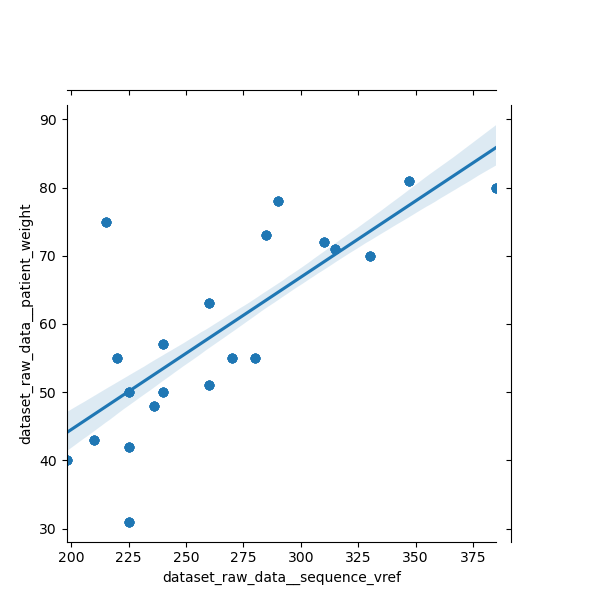

R = 0.77
p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__patient_height


<IPython.core.display.Javascript object>


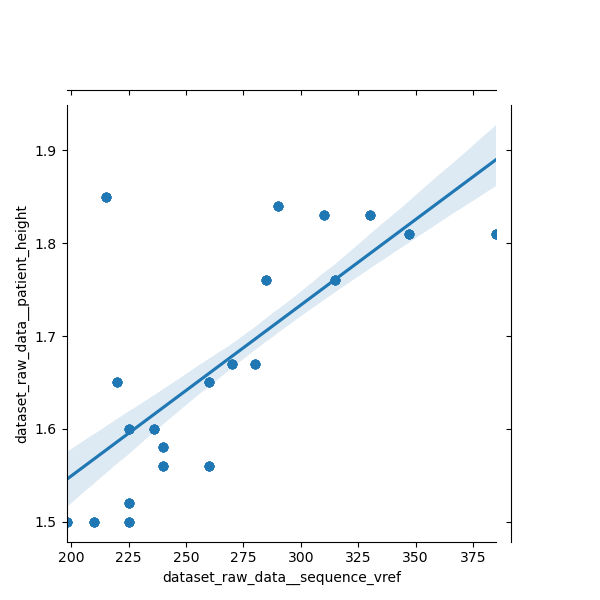

R = 0.73
p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__sequence_pulse_exc_duration


<IPython.core.display.Javascript object>


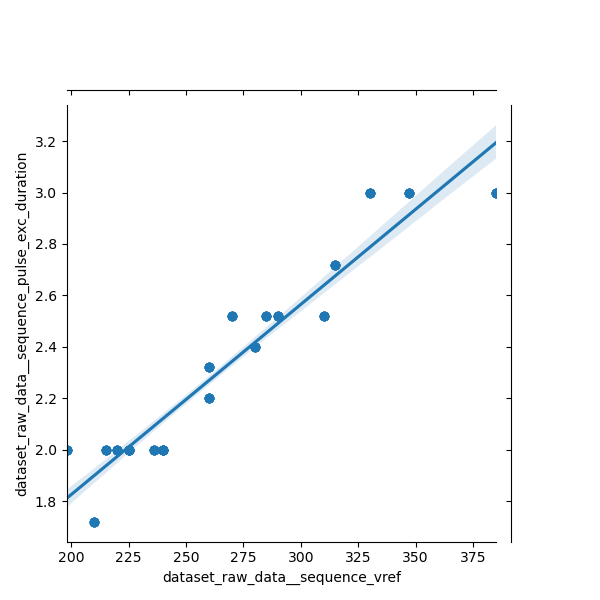

R = 0.96
p1 = dataset_raw_data__sequence_te | p2 = dataset_raw_data__sequence_pulse_rfc_duration


<IPython.core.display.Javascript object>


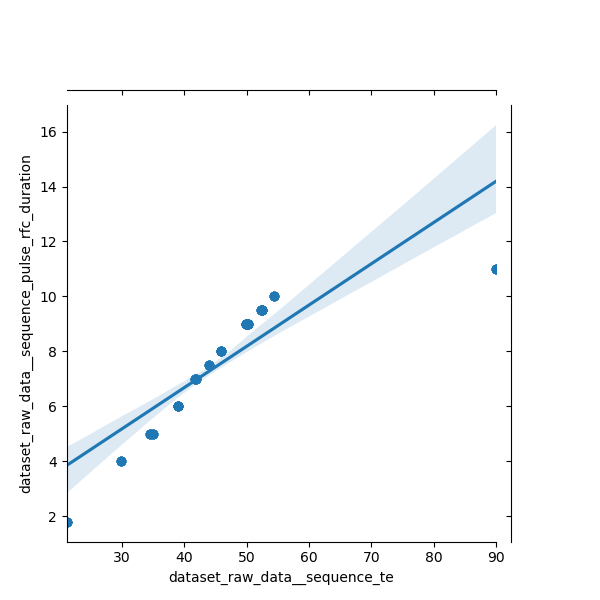

R = 0.87
p1 = dataset_raw_data__sequence_te | p2 = dataset_raw_data__sequence_pulse_rfc_n


<IPython.core.display.Javascript object>


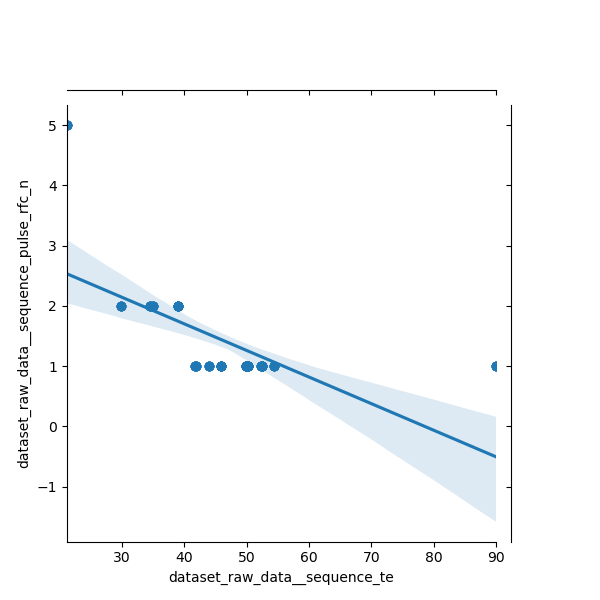

R = -0.63


In [16]:
# list pairs of keys to plot correlation
interesting_corrs = {}
interesting_corrs["dataset_snr_final"] = ["reco_pipeline_dataset[1]_raw_data__sequence_shims[7]",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                         "dataset_prerej_amplitude_mean",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]

interesting_corrs["dataset_patient_bmi"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]

interesting_corrs["dataset_lw"] = ["dataset_raw_data__noise_level",
                                   "dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0",
                                            "dataset_raw_data__patient_weight",
                                            "dataset_voxel_vol_cm3",
                                            "params_fit_obj$NAA_CH3$cm$err_prct",
                                            "dataset_raw_data__patient_height",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_r",
                                            "dataset_raw_data__sequence_pulse_rfc_n",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]


interesting_corrs["dataset_raw_data__sequence_vref"] = ["dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__patient_weight",
                                            "dataset_raw_data__patient_height",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_duration"]


interesting_corrs["dataset_raw_data__sequence_te"] = ["dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                                       "dataset_raw_data__sequence_pulse_rfc_n"]

# now plot all this stuff
for p1, p2_list in interesting_corrs.items():
    for p2 in p2_list:

        this_df_num = df_num.loc[ ~np.isnan(df_num[p1])
                                & ~np.isinf(df_num[p1])
                                & ~np.isnan(df_num[p2])
                                & ~np.isinf(df_num[p2])]

        rrr = this_df_num[p1].corr(this_df_num[p2])
        if(np.abs(rrr) > 0.5):
            print("p1 = %s | p2 = %s" % (p1, p2))
            x = df[p1].astype(np.float)
            y = df[p2].astype(np.float)
            g = sns.JointGrid(x=x, y=y)
            g.plot_joint(sns.regplot)
            # g.plot_marginals(sns.histplot, kde=True)
            print("R = %.2f" % x.corr(y))


# Convert to a tidy/long style
* break parameters object into multiple columns
* in order to be able to do seaborn plots easily

In [17]:
def convert_to_tidy_df(this_df):
    # first find the columns to break
    sim_params_col_list = []
    for c in this_df.columns:
        if("$" in c):
            sim_params_col_list.append(c)

    # find all columns not included in previous list
    this_df = this_df.reset_index()
    id_vars_list = []
    for c in this_df.columns:
        if(c not in sim_params_col_list):
            id_vars_list.append(c)

    # melt all those param columns
    this_df = this_df.melt(id_vars=id_vars_list, var_name="melted_params_name", value_name="param_val")         
            
    # split columns into metabolite and parameter name and err
    melted_params_name_col = this_df["melted_params_name"]

    melted_params_name_col_par_type = melted_params_name_col.str.split("$").str[0]
    melted_params_name_col_met = melted_params_name_col.str.split("$").str[1]
    melted_params_name_col_par = melted_params_name_col.str.split("$").str[2]
    melted_params_name_col_val_type = melted_params_name_col.str.split("$").str[3]
    this_df["param_p_type"] = melted_params_name_col_par_type
    this_df["param_m"] = melted_params_name_col_met
    this_df["param_p"] = melted_params_name_col_par
    this_df["param_p_val_type"] = melted_params_name_col_val_type

    return(this_df)


# tidy things up
df_sc = convert_to_tidy_df(df_sc)
df_sc_no_dr = convert_to_tidy_df(df_sc_no_dr)
df_sc_no_dr_no_rea = convert_to_tidy_df(df_sc_no_dr_no_rea)

df_brain = convert_to_tidy_df(df_brain)

# Free some memory

In [18]:
def clean_mem(dir_result, except_list):
    for var_name in dir_result:
        if(eval("type(" + var_name + ")") == pd.DataFrame and var_name not in except_list):
            del globals()[var_name]

# remove useless variables
clean_mem(dir(), ["df_sc", "df_sc_no_dr", "df_sc_no_dr_no_rea", "df_brain"])
df_sc.info()
df_sc_no_dr.info()
df_sc_no_dr_no_rea.info()
df_brain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50274 entries, 0 to 50273
Columns: 4786 entries, fit_hash to param_p_val_type
dtypes: bool(436), datetime64[ns](30), float64(2406), int64(3), object(1911)
memory usage: 1.6+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50274 entries, 0 to 50273
Columns: 3771 entries, fit_hash to param_p_val_type
dtypes: bool(516), datetime64[ns](20), float64(1825), int64(93), object(1317)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50274 entries, 0 to 50273
Columns: 3738 entries, fit_hash to param_p_val_type
dtypes: bool(516), datetime64[ns](20), float64(1795), int64(94), object(1313)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14364 entries, 0 to 14363
Columns: 3547 entries, fit_hash to param_p_val_type
dtypes: bool(436), datetime64[ns](18), float64(1579), int64(3), object(1511)
memory usage: 346.9+ MB


# Optimal fit strategy

## Brain data

### Fit strategies & R2/FQN
Which one to choose? Based on fit criteria (RSQ, FQN)

<IPython.core.display.Javascript object>


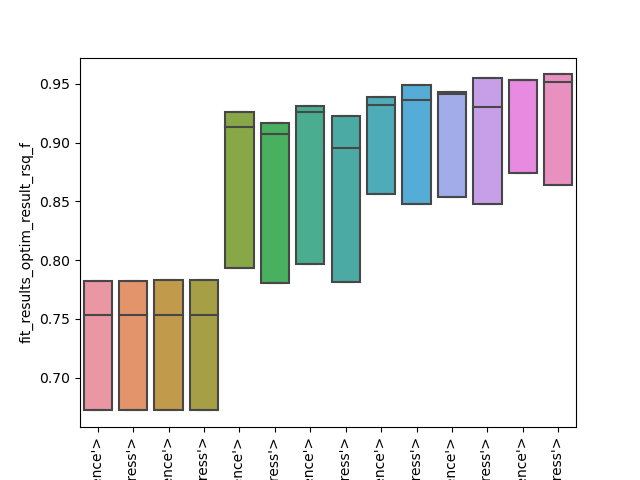

<IPython.core.display.Javascript object>


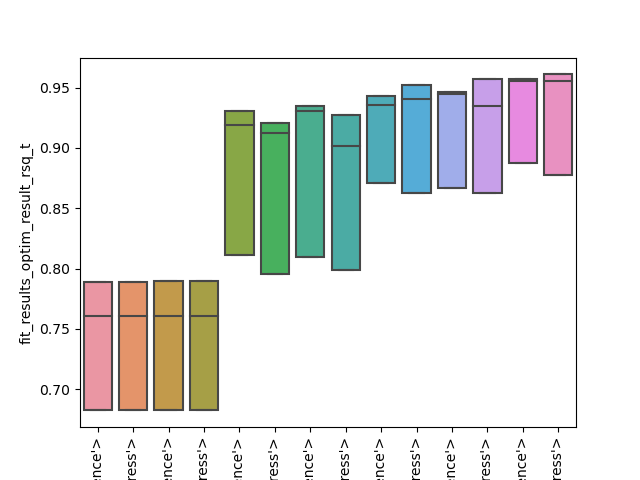

<IPython.core.display.Javascript object>


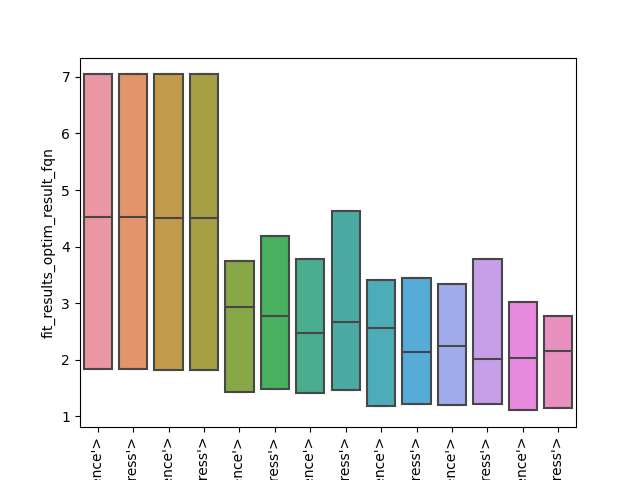

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, "singlets_<class 'mrs.sim.mrs_sequence'>"),
  Text(1, 0, "singlets_<class 'mrs.sim.mrs_seq_press'>"),
  Text(2, 0, "singlets_free_<class 'mrs.sim.mrs_sequence'>"),
  Text(3, 0, "singlets_free_<class 'mrs.sim.mrs_seq_press'>"),
  Text(4, 0, "singlets_CH2s_mI_<class 'mrs.sim.mrs_sequence'>"),
  Text(5, 0, "singlets_CH2s_mI_<class 'mrs.sim.mrs_seq_press'>"),
  Text(6, 0, "free_singlets_CH2s_mI_<class 'mrs.sim.mrs_sequence'>"),
  Text(7, 0, "free_singlets_CH2s_mI_<class 'mrs.sim.mrs_seq_press'>"),
  Text(8, 0, "singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_sequence'>"),
  Text(9, 0, "singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>"),
  Text(10, 0, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_sequence'>"),
  Text(11, 0, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>"),
  Text(12, 0, "free_singlets_hardest_<class 'mrs.sim.mrs_sequence'>"),
  Text(13, 0, "free_singlets_hardest_<class '

In [19]:
df = df_brain

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_f",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_t",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_fqn",
                data=df)
plt.xticks(rotation=90)

Numerical fitting criteria show that simulating PRESS of sLASER does not make a huge difference... Maybe a little better for sLASER (surprisingly).

### Fit strategies & CRBs
Which strategy to choose? Which sequence simulation is the best? Based on metabolite concentration CRBs

<IPython.core.display.Javascript object>


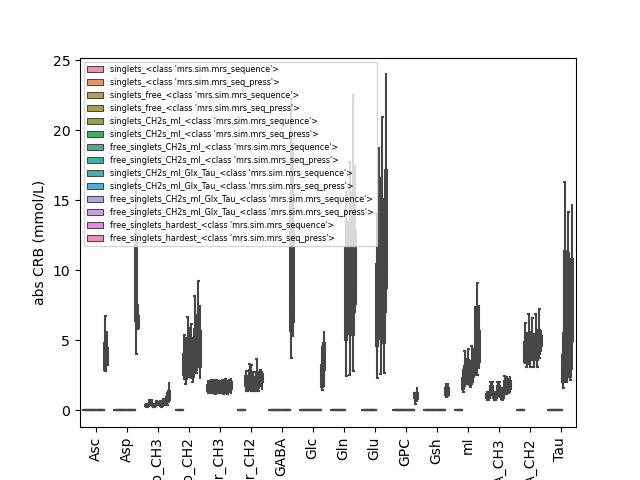

<IPython.core.display.Javascript object>


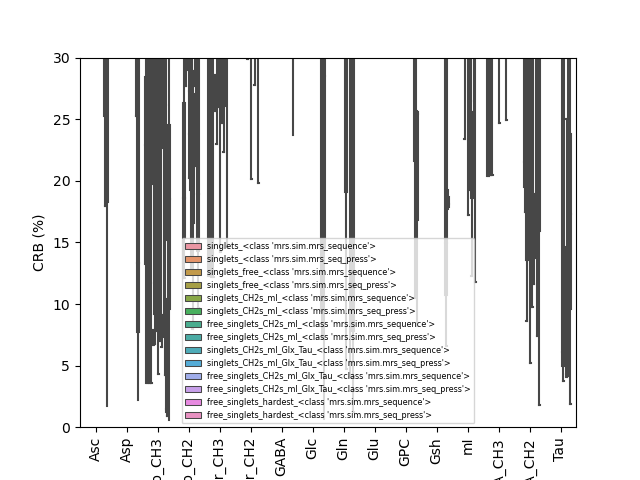

(0.0, 30.0)

In [20]:
df = df_brain

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_obj") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("abs CRB (mmol/L)")
plt.legend(fontsize='xx-small')

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("CRB (%)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])


* CRBs are very low... Too low when comparing with literature. Something fishy. 
* Results from previous sections confirmed here. The PRESS simulated sequence should be used for the fitting. sLASER simulated sequence showed systematic CRB increase, especially for coupled metabolites...
    * :( We have a bug.
* When considering all metabolites to fit, some main metabolites Cr, Cho, NAA, mI see their CRBs increase, not good. The optimal strategy seems to be the "free_singlets_CH2s_mI_Glx_Tau" with PRESS

## Spinal cord data

### Fit strategies & R2/FQN
Which one to choose? Based on fit criteria (RSQ, FQN)

<IPython.core.display.Javascript object>


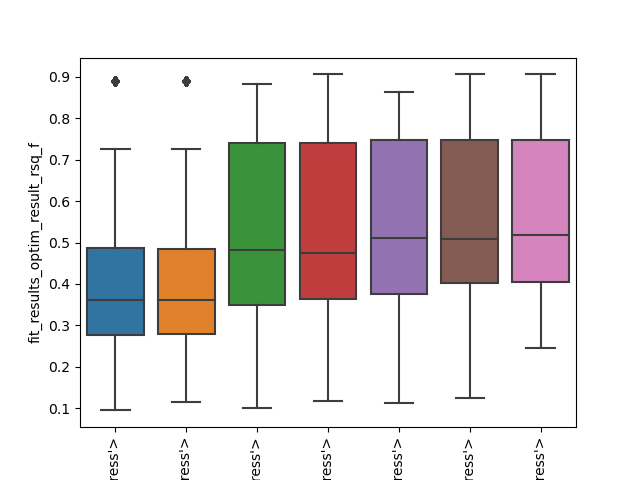

<IPython.core.display.Javascript object>


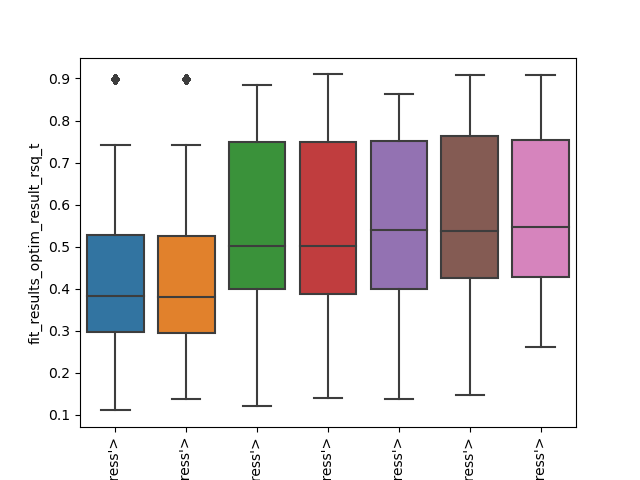

<IPython.core.display.Javascript object>


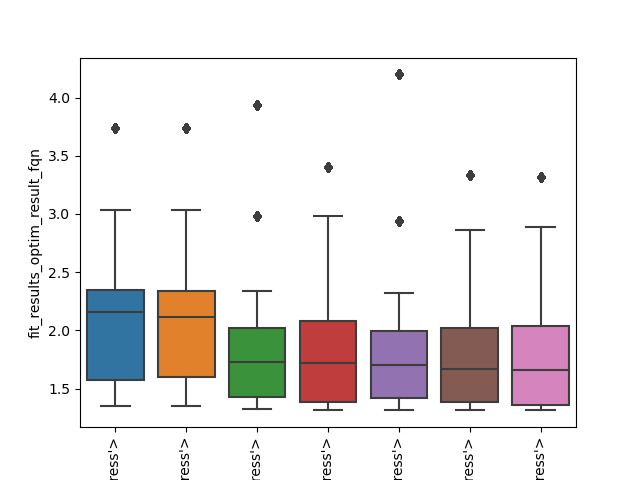

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, "singlets_<class 'mrs.sim.mrs_seq_press'>"),
  Text(1, 0, "singlets_free_<class 'mrs.sim.mrs_seq_press'>"),
  Text(2, 0, "singlets_CH2s_mI_<class 'mrs.sim.mrs_seq_press'>"),
  Text(3, 0, "free_singlets_CH2s_mI_<class 'mrs.sim.mrs_seq_press'>"),
  Text(4, 0, "singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>"),
  Text(5, 0, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>"),
  Text(6, 0, "free_singlets_hardest_<class 'mrs.sim.mrs_seq_press'>")])

In [21]:
df = df_sc

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_f",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_t",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_fqn",
                data=df)
plt.xticks(rotation=90)

Numerical fitting criteria show that simulating PRESS of sLASER does not make a huge difference... Maybe a little better for sLASER (surprisingly).

### Fit strategies & CRBs
Which strategy to choose? Based on metabolite concentration CRBs

<IPython.core.display.Javascript object>


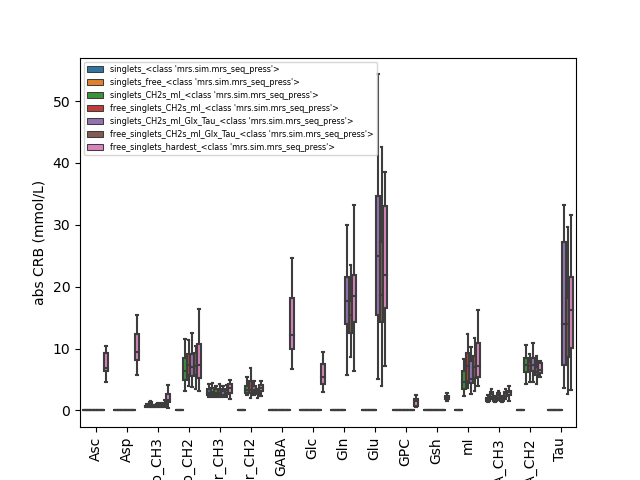

<IPython.core.display.Javascript object>


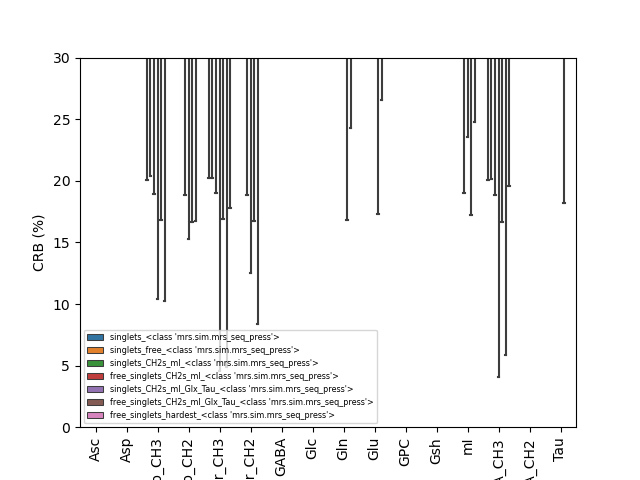

(0.0, 30.0)

In [22]:
df = df_sc

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_obj") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("abs CRB (mmol/L)")
plt.legend(fontsize='xx-small')

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "err_prct") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("CRB (%)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])


* Same as on the brain :
* Very CRBs in general, this is suspicious... 
* Best strategy is "free_singlets_CH2s_mI_Glx_Tau" with PRESS

### Fit strategies & mean/std cm of NAA/CHo/Cr
Which strategy to choose? Based on group mean/std of main metabolites NAA/Cho/Cre concentrations

<IPython.core.display.Javascript object>


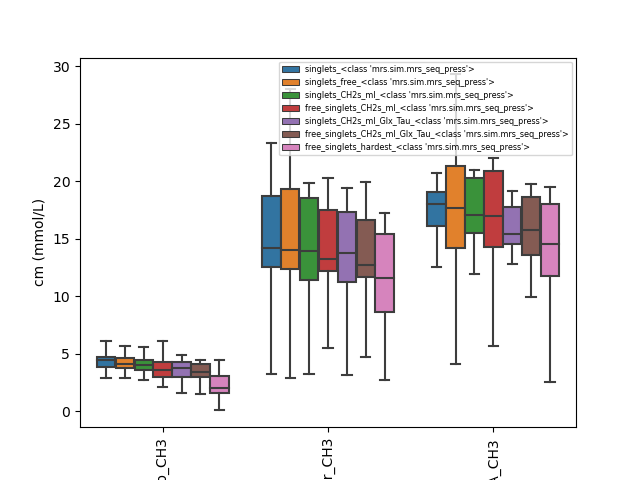

In [23]:
df = df_sc

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "val") &
                 (df["param_m"].isin(["NAA_CH3", "Cho_CH3", "Cr_CH3"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("cm (mmol/L)")
plt.legend(fontsize='xx-small')


### [FIG] Fit strategies
Which strategy to choose?

In [24]:
def run_p1_p2_stats(this_df, threshold_snr, threshold_lw, threshold_fqn):

    # first, make the stats for P1
    df_filtered = this_df.loc[  (this_df["dataset_snr_final"] > threshold_snr) &
                                (this_df["dataset_lw"] < threshold_lw) &
                                (this_df["fit_results_optim_result_fqn"] < threshold_fqn)]
    
    df_filtered_rej = this_df.loc[  ((this_df["dataset_snr_final"] < threshold_snr) |
                                (this_df["dataset_lw"] > threshold_lw) |
                                (this_df["fit_results_optim_result_fqn"] > threshold_fqn))]

    # deal with orphans
    df_p1 = df_filtered.loc[(df_filtered["study"] == 1)]

    df_p2_orphan = df_filtered.loc[ (df_filtered["study"] == 2) &
                                    ~(df_filtered["patient"].isin(list(df_p1["patient"].unique()))) ]

    # changed to P1
    print("Number of P2 orphans fixed = %d" % len(df_p2_orphan["patient_study_id"].unique()))
    for this_index in list(df_p2_orphan.index):
        df_filtered.at[this_index, "study"] = 1
        df_filtered.at[this_index, "patient_study_id"] = df_filtered.at[this_index, "patient_study_id"] + "_orphan"

    
    # now deal with P1 stats only
    df_p1 = df_filtered.loc[(df_filtered["study"] == 1)]
        
    # txt output
    print("Number of P1 patients = %d" % len(df_p1["patient"].unique()))

    print("Metabolite".ljust(15) + " \t Area (SD) \t Fit (SD) \t raw CRB (med) \t ratio CRB (med) \t ratio CV (%)")
    for m in ["Cr_CH3", "Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:

        this_df_area = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "val")]

        this_df_fit_raw_err = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_obj") & 
                         (df_p1["param_p_val_type"] == "err")]  

        this_df_fit_ratio_err = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "err_prct")]  


        print("%s \t %.2f (%.2f) \t %.2f (%.2f) \t %06.2f \t\t %06.2f \t\t %06.2f" % 
              (m.ljust(15),
               this_df_area["param_val"].mean(),
               this_df_area["param_val"].std(),
               this_df_fit_ratio["param_val"].mean(),
               this_df_fit_ratio["param_val"].std(),
               this_df_fit_raw_err["param_val"].median(),
               this_df_fit_ratio_err["param_val"].median(),
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))

    # now deal with variability between P1 and P2
    df_p2 = df_filtered.loc[df_filtered["study"] == 2]

    df_p1 = df_filtered.loc[(df_filtered["patient"].isin(list(df_p2["patient"].unique()))) &
                            (df_filtered["study"] == 1)]

    df_p1_p2 = df_p1.append(df_p2)
    
    # txt output
    print()
    print("Number of P1 patients who did P2 = %d" % len(df_p1_p2["patient"].unique()))

    print("Metabolite".ljust(15) + "area CV (%) \t fit CV (%)")
    for m in ["Cr_CH3", "Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:
    
        this_df_area_ratio = df_p1_p2.loc[(df_p1_p2["param_m"] == m) &
                         (df_p1_p2["param_p"] == "cm") &
                         (df_p1_p2["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_p1_p2["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_p1_p2.loc[(df_p1_p2["param_m"] == m) &
                         (df_p1_p2["param_p"] == "cm") &
                         (df_p1_p2["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1_p2["param_p_val_type"] == "val")]

        print("%s %.2f \t\t %.2f" % 
              (m.ljust(15),
               this_df_area_ratio["param_val"].std() / this_df_area_ratio["param_val"].mean() * 100.0,
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))
        
    return(df_filtered, df_filtered_rej)

 
threshold_snr_test = 15
threshold_lw_test = 20
threshold_fqn_test = 1.9
df, _ = run_p1_p2_stats(df_sc, threshold_snr_test, threshold_lw_test, threshold_fqn_test)

Number of P2 orphans fixed = 1
Number of P1 patients = 7
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (med) 	 ratio CRB (med) 	 ratio CV (%)
Cr_CH3          	 1.00 (0.00) 	 1.00 (0.00) 	 001.90 		 000.00 		 000.00
Cho_CH3         	 0.35 (0.13) 	 0.40 (0.18) 	 000.66 		 011.47 		 046.14
NAA_CH3         	 1.44 (0.25) 	 1.64 (0.51) 	 001.78 		 008.36 		 031.04
Gln             	 0.00 (0.00) 	 0.45 (0.74) 	 000.00 		 043.19 		 165.20
Glu             	 0.00 (0.00) 	 1.46 (2.31) 	 000.00 		 023.11 		 157.87
mI              	 0.00 (0.00) 	 1.28 (0.88) 	 003.84 		 015.01 		 068.63
Tau             	 0.00 (0.00) 	 0.75 (1.62) 	 000.00 		 040.08 		 215.40

Number of P1 patients who did P2 = 4
Metabolite     area CV (%) 	 fit CV (%)
Cr_CH3          0.00 		 0.00
Cho_CH3         40.90 		 56.87
NAA_CH3         15.87 		 34.80
Gln             nan 		 156.33
Glu             nan 		 183.26
mI              nan 		 86.88
Tau             nan 		 189.80


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


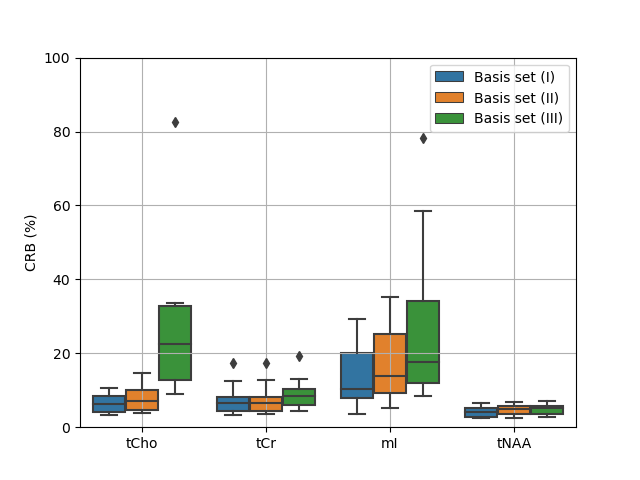

In [25]:
this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_obj") & 
                 (df["param_p_val_type"] == "err_prct") &
                 (df["param_m"].isin(["NAA_CH3", "Cho_CH3", "Cr_CH3", "mI"])) &
                 (df["fit_strategy_name"].isin(["free_singlets_CH2s_mI_<class 'mrs.sim.mrs_seq_press'>",
                                      "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>",
                                      "free_singlets_hardest_<class 'mrs.sim.mrs_seq_press'>"]))]

this_df["param_m"] = this_df["param_m"].str.replace("NAA_CH3", "tNAA")
this_df["param_m"] = this_df["param_m"].str.replace("Cho_CH3", "tCho")
this_df["param_m"] = this_df["param_m"].str.replace("Cr_CH3", "tCr")

this_df["fit_strategy_name"] = this_df["fit_strategy_name"].str.replace("free_singlets_CH2s_mI_<class 'mrs.sim.mrs_seq_press'>", "Basis set (I)")
this_df["fit_strategy_name"] = this_df["fit_strategy_name"].str.replace("free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>", "Basis set (II)")
this_df["fit_strategy_name"] = this_df["fit_strategy_name"].str.replace("free_singlets_hardest_<class 'mrs.sim.mrs_seq_press'>", "Basis set (III)")

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df)

plt.ylabel("CRB (%)")
plt.grid("on")
plt.ylim([0, 100])
plt.legend()
plt.xlabel("")

plt.savefig("./notebooks/figs/fig_basissets.svg")

That was JP's suggestion.
* Confirms previous observations on CRBs:
    * The best strategy is "free_singlets_CH2s_mI_Glx_Tau" with PRESS
    * If we add more metabolites, mean/std concentrations are affected!

## Correlated with MRS data quality?

### CRBs & Fit strategy & SNR & LW
Checking if the previous results also applies to bad quality data (in terms of SNR/LW). Would it be more interesting for example to use a simple fit strategy (NAA/Cho/cre) on a low-SNR-bad-LW MRS data?

<IPython.core.display.Javascript object>


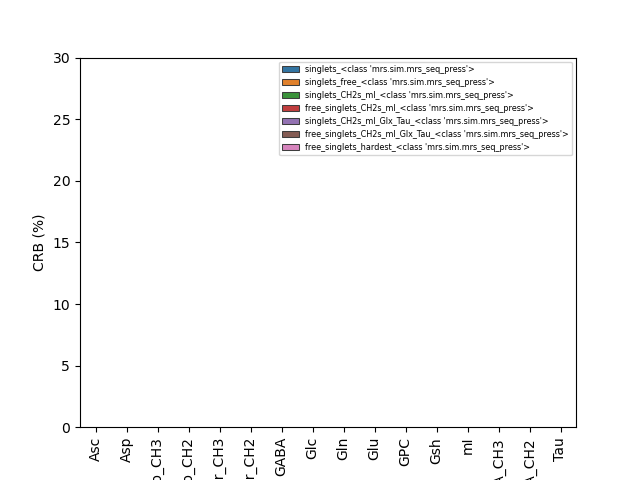

<IPython.core.display.Javascript object>


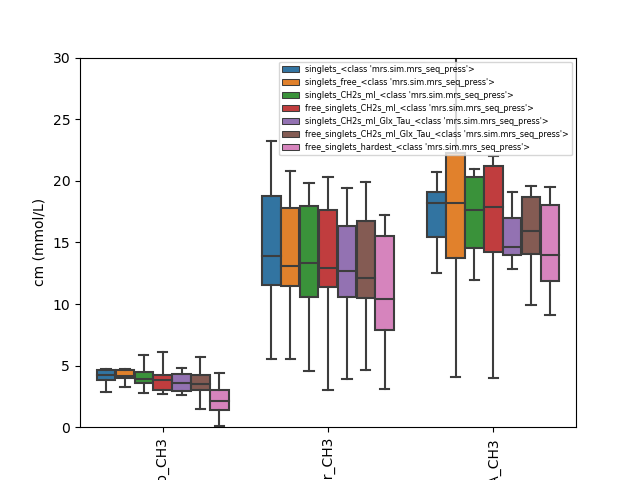

(0.0, 30.0)

In [26]:
df = df_sc

snr_threshold = 25
lw_threshold = 18

this_df = df.loc[( (df["dataset_snr_final"] < snr_threshold) | (df["dataset_lw"] > lw_threshold) ) &
                 (df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "err_prct") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("CRB (%)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])

this_df = df.loc[( (df["dataset_snr_final"] < snr_threshold) | (df["dataset_lw"] > lw_threshold) ) &
                 (df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "val") &
                 (df["param_m"].isin(["NAA_CH3", "Cho_CH3", "Cr_CH3"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("cm (mmol/L)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])


## Drop non-optimal fit strategies
To save memory and go on with stats

In [27]:
def keep_only_this_fit_strategy(this_df, fs_name):
    this_df = this_df.loc[this_df["fit_strategy_name"].str.contains(fs_name)]
    return(this_df)

df_brain = keep_only_this_fit_strategy(df_brain, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>")
df_sc = keep_only_this_fit_strategy(df_sc, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>")
df_sc_no_dr = keep_only_this_fit_strategy(df_sc_no_dr, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>")
df_sc_no_dr_no_rea = keep_only_this_fit_strategy(df_sc_no_dr_no_rea, "free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>")

df_sc["fit_hash"].unique()


array(['fab399d5f2839b56629367308f64505e',
       'c67cab66843429ff6ae6bf389c6d9365',
       'f97a0f271d41b9cb673c9ac4974ebe04',
       '29c6c771a114d3401a1df03b575516c8',
       'd9e882cb59272fa8561fd84a694fb909',
       'd3dc71dd4d0d1971705190418400d632',
       '4ea53a479ddd13340978924f45c3ccca',
       '117cae5be289ed11b8463750c2b41e19',
       '493b111394630b10b75769e289fa4e09',
       '6d16f69f0bff2dd968acaad67a84637c',
       '6a022d488532ecee80e13bac328da6bf',
       '4eea1616b6b004f3909c7cdbd8d12e07',
       '7ea1e62ca0f751b84a36bc5c39e36ca6',
       '9d5d9a3bd09278888f0b60a34d49755a',
       '6dab0412d2dfd86faffc86e81469bac1',
       '934a6b97d5cfcfb9ad0a17cbce8b689a',
       'e56ff2e3b032c4b59a09beeaaa6ea188',
       '3b46e436f989f351f7ab3d775f0ca364',
       'd6b88a8a438e5fbd2320bf5596b7d541',
       '6525eeea6415ba645cb8749d0fe1097d',
       '569a64ad592e6696bba2ea835dda98af'], dtype=object)

In [28]:
def remove_not_quantified_metabolites(this_df):
    # remove metabolite rows which not estimated
    for m in this_df["param_m"].unique():
        this_met_concentrations = this_df.loc[  (this_df["param_m"] == m) & 
                                           (this_df["param_p"] == "cm") &
                                           (this_df["param_p_val_type"] == "val")]["param_val"]

        if(len(this_met_concentrations.unique())  in (1, 2)):
            # this metabolite cm is always 0 or nan, remove it
            this_met_indexes = this_df.loc[(this_df["param_m"] == m)].index
            this_df = this_df.drop(this_met_indexes)

    return(this_df)

df_brain = remove_not_quantified_metabolites(df_brain)
df_sc = remove_not_quantified_metabolites(df_sc)
df_sc_no_dr = remove_not_quantified_metabolites(df_sc_no_dr)
df_sc_no_dr_no_rea = remove_not_quantified_metabolites(df_sc_no_dr_no_rea)


## Merge all SC dfs

In [29]:
df_sc["reco_type"] = "optimal"
df_sc_no_dr["reco_type"] = "no_data_rejection"
df_sc_no_dr_no_rea["reco_type"] = "no_data_rejection_no_realignement"

df_sc = pd.concat([df_sc, df_sc_no_dr, df_sc_no_dr_no_rea])


## Free some memory

In [30]:
# remove useless variables
clean_mem(dir(), ["df_sc", "df_brain"])  
df_sc.info()
df_brain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14742 entries, 887 to 50272
Columns: 4795 entries, fit_hash to reco_pipeline_job_list[8]_final_npts
dtypes: bool(436), datetime64[ns](30), float64(2410), int64(3), object(1916)
memory usage: 496.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 263 to 14361
Columns: 3547 entries, fit_hash to param_p_val_type
dtypes: bool(436), datetime64[ns](18), float64(1579), int64(3), object(1511)
memory usage: 17.0+ MB


# Estimations & SNR & LW

<IPython.core.display.Javascript object>


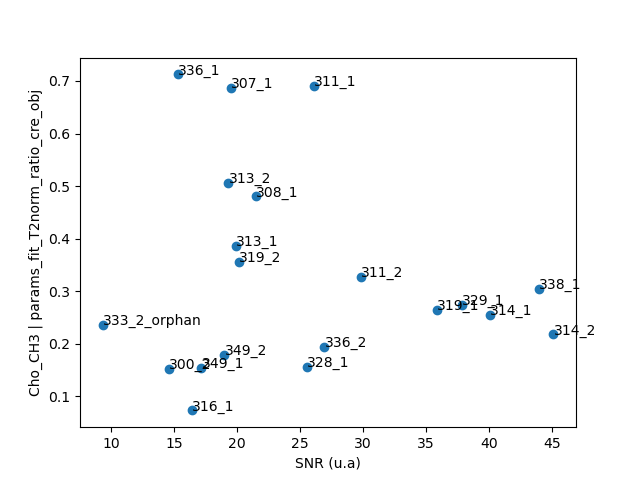

R = -0.13


<IPython.core.display.Javascript object>


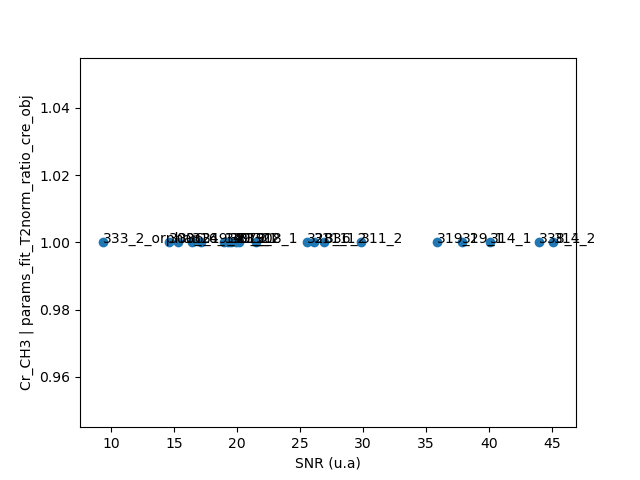

R = nan


<IPython.core.display.Javascript object>


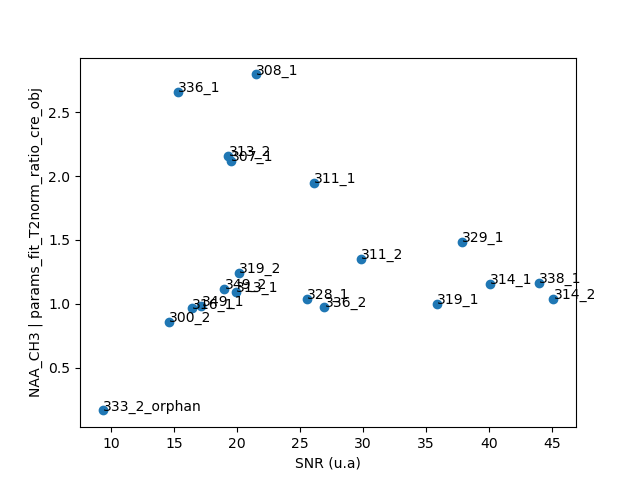

R = -0.07


<IPython.core.display.Javascript object>


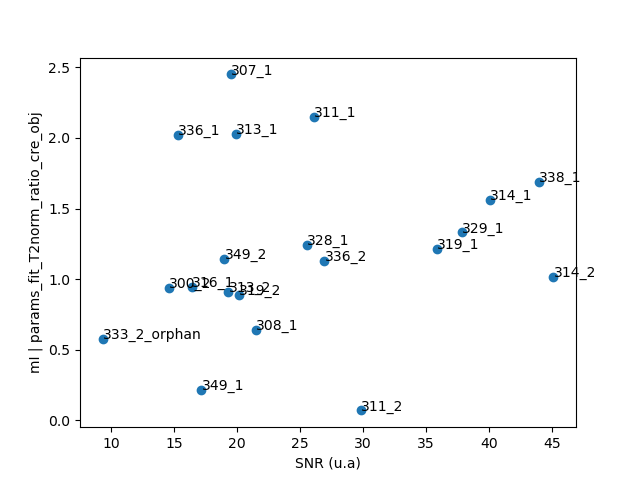

R = 0.14


<IPython.core.display.Javascript object>


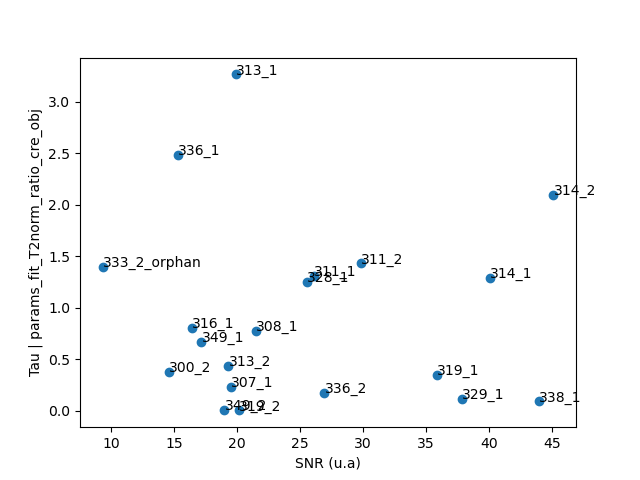

R = -0.06


In [31]:
df = df_sc

def label_point(x, y, val, ax, font_size=10, x_offset=0.0, y_offset=0.0):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + .02 + x_offset, point['y'] + y_offset, str(point['val']), fontsize=font_size)


for m in ["Cho_CH3", "Cr_CH3", "NAA_CH3", "mI", "Tau"]:
    
    for p in [#'params_area_pnorm_T2norm_abs_obj',
                #'params_area_pnorm_T2norm_ratio_cre_obj',
                #'params_fit_T2norm_abs_obj',
                'params_fit_T2norm_ratio_cre_obj']:
    
        this_df = df.loc[(df["param_p"] == "cm") &
                         (df["param_m"] == m) &
                         (df["param_p_type"] == p) & 
                         (df["param_p_val_type"] == "val") &
                         (df["reco_type"] == "optimal") &
                         (df["patient_study_id"] != "300_1")] # remove Pelayo because no REF scan, fucking up abs estimations!

        x = this_df["dataset_snr_final"]
        y = this_df["param_val"]
        # g = sns.JointGrid(x=x, y=y)
        # g.plot_joint(sns.regplot)
        # g.plot_marginals(sns.histplot, kde=True)
        # g.ax_joint.set_xlabel("SNR (u.a)")
        # g.ax_joint.set_ylabel("%s | %s" % (m, p))
        plt.figure()
        plt.scatter(x, y)
        plt.xlabel("SNR (u.a)")
        plt.ylabel("%s | %s" % (m, p))        
        print("R = %.2f" % x.corr(y))
        
        label_point(x, y, this_df["patient_study_id"], plt.gca())
    

* In general, seems that metabolite ratios to Cr decrease when SNR increases. Not sure what the reason is...
* More important. Let's try to identify some outlier scans (in order of out intensity):
    * Cho/Cr: 307_1, 311_1, 336_1 then 313_2, 308_1 then 313_1, 319_2, 333_2
    * NAA/Cr: 308_1, 336_1 then 307_1, 313_2 then 311_1, 313_1
    * mI/cr: 307_1, 311_1, 313_1, 336_1
* Scans 307_1, 311_1, 336_1, 313_1/2, 308_1, 308_1, 311_1 are increasing result variability. How different are they from the rest? SNR/LW/CRB? 


# CRBs & SNR & LW

<IPython.core.display.Javascript object>


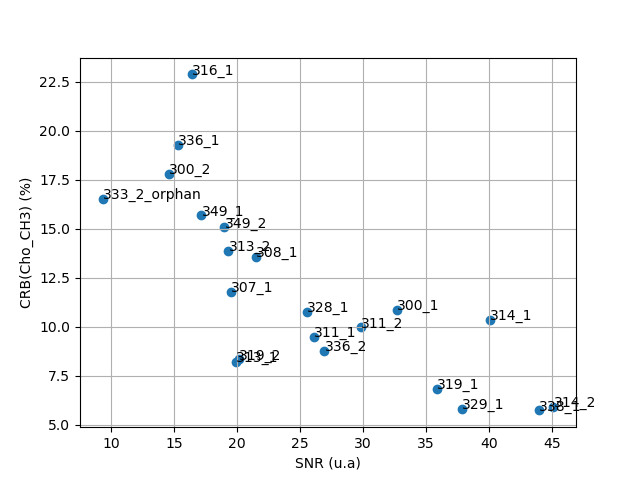

R = -0.77


<IPython.core.display.Javascript object>


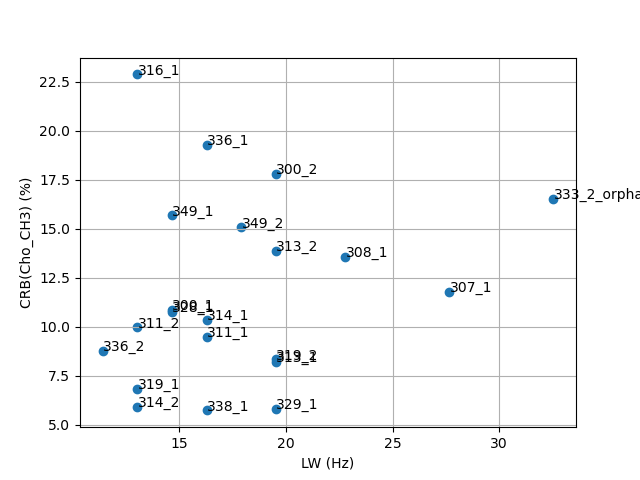

R = 0.19


<IPython.core.display.Javascript object>


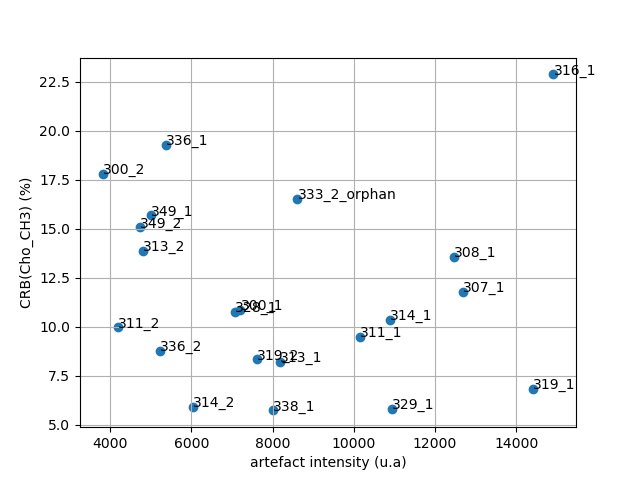

R = -0.05


<IPython.core.display.Javascript object>

R = 0.16


<IPython.core.display.Javascript object>


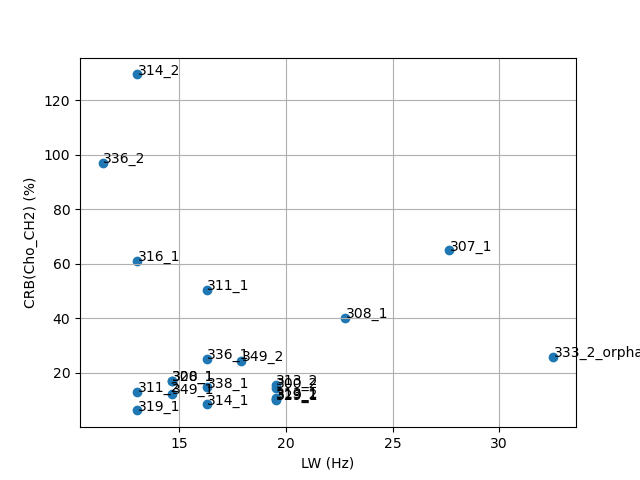

R = -0.15


<IPython.core.display.Javascript object>

R = 0.04


<IPython.core.display.Javascript object>


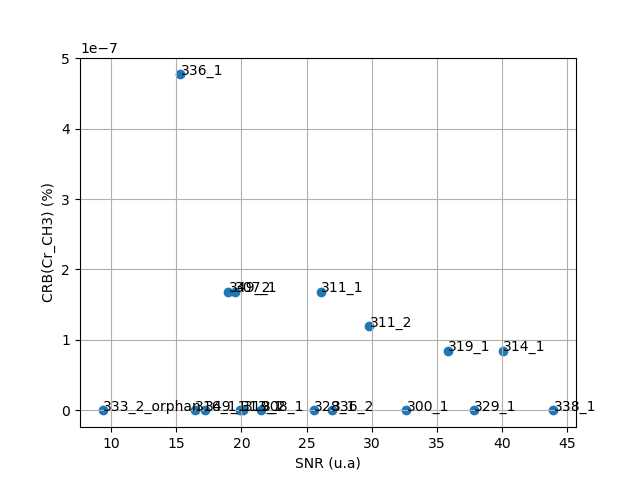

R = -0.21


<IPython.core.display.Javascript object>

R = -0.03


<IPython.core.display.Javascript object>


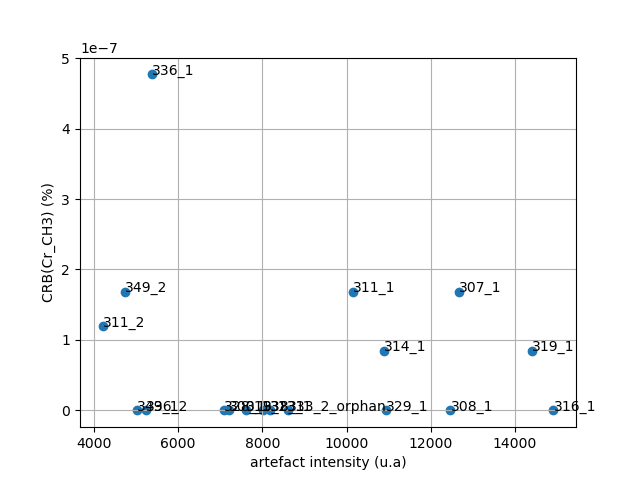

R = -0.19


<IPython.core.display.Javascript object>

R = -0.29


<IPython.core.display.Javascript object>


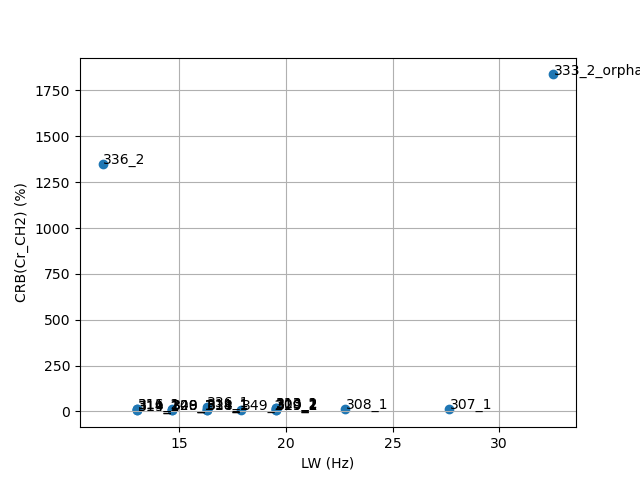

R = 0.38


<IPython.core.display.Javascript object>

R = -0.10


<IPython.core.display.Javascript object>


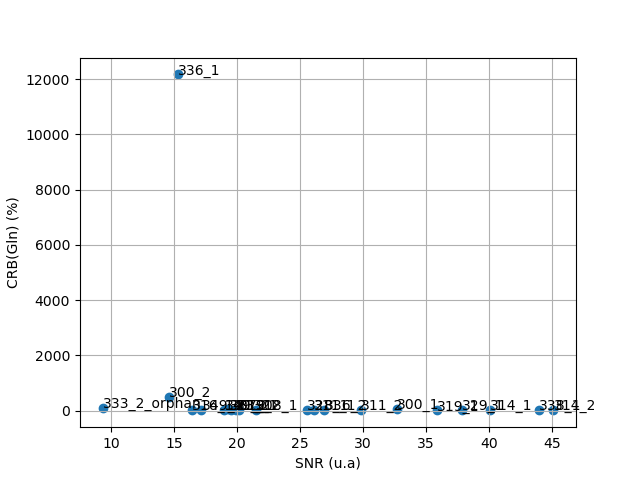

R = -0.24


<IPython.core.display.Javascript object>

R = -0.06


<IPython.core.display.Javascript object>

R = -0.20


<IPython.core.display.Javascript object>


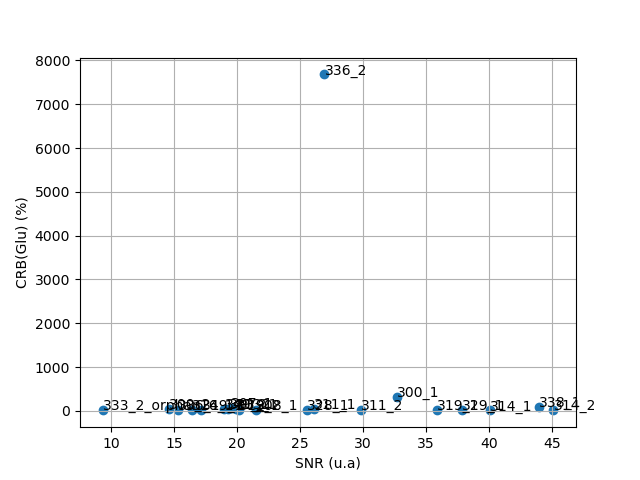

R = 0.04


<IPython.core.display.Javascript object>

R = -0.28


<IPython.core.display.Javascript object>


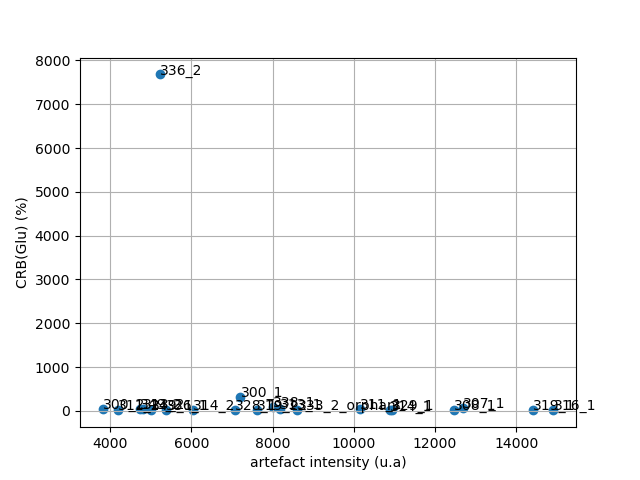

R = -0.20


<IPython.core.display.Javascript object>

R = 0.03


<IPython.core.display.Javascript object>


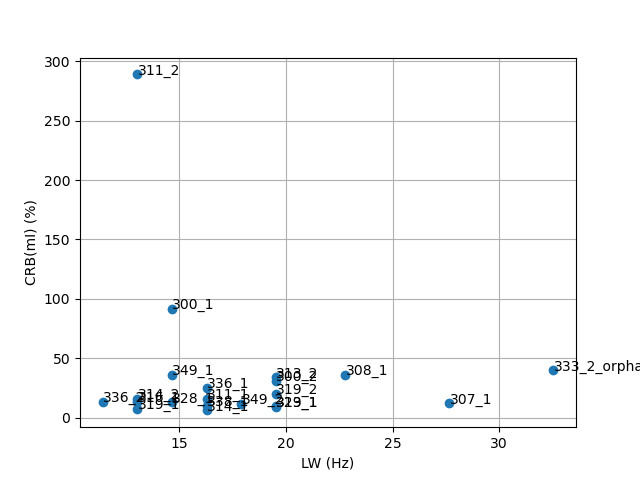

R = -0.16


<IPython.core.display.Javascript object>

R = -0.33


<IPython.core.display.Javascript object>


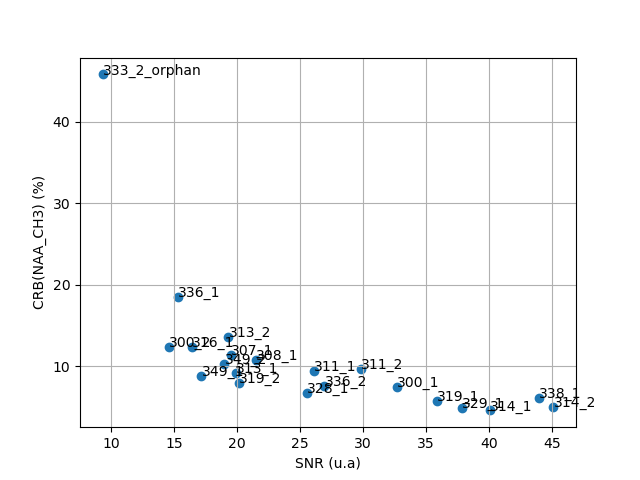

R = -0.62


<IPython.core.display.Javascript object>

R = 0.69


<IPython.core.display.Javascript object>

R = -0.06


<IPython.core.display.Javascript object>


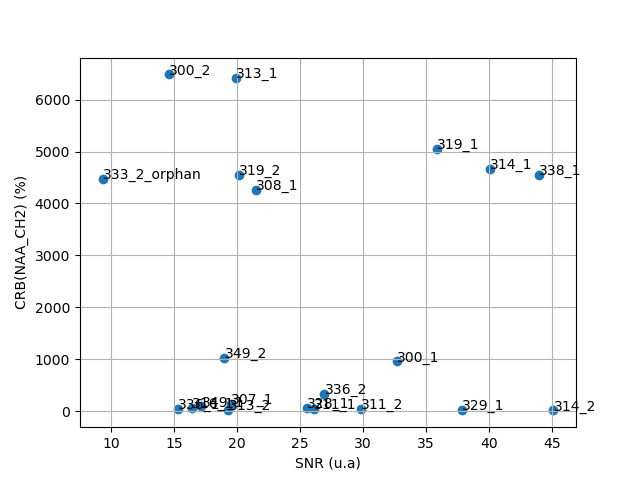

R = -0.04


<IPython.core.display.Javascript object>

R = 0.31


<IPython.core.display.Javascript object>


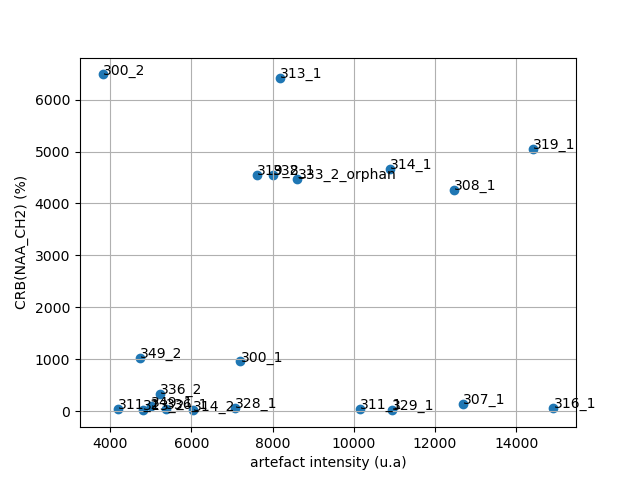

R = 0.16


<IPython.core.display.Javascript object>


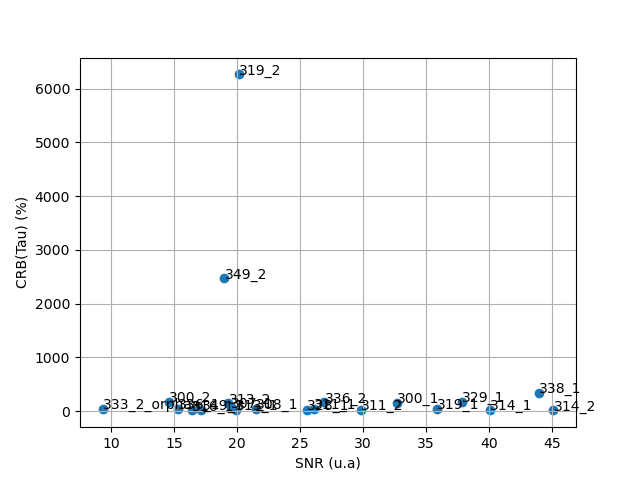

R = -0.15


<IPython.core.display.Javascript object>


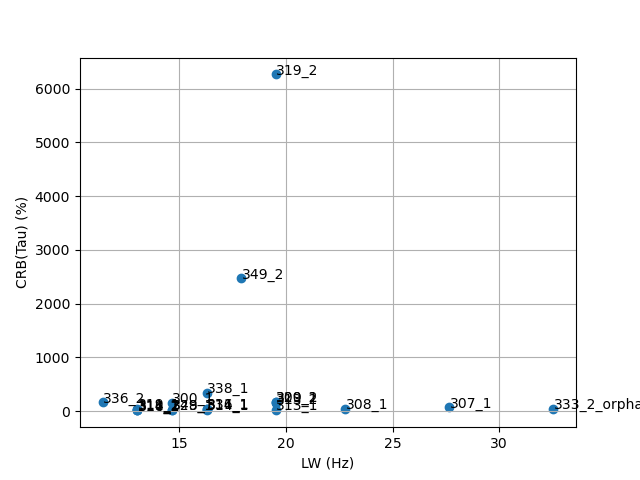

R = 0.08


<IPython.core.display.Javascript object>

R = -0.13


<IPython.core.display.Javascript object>

R = -0.16


<IPython.core.display.Javascript object>

R = 0.18


<IPython.core.display.Javascript object>

R = -0.18


<IPython.core.display.Javascript object>


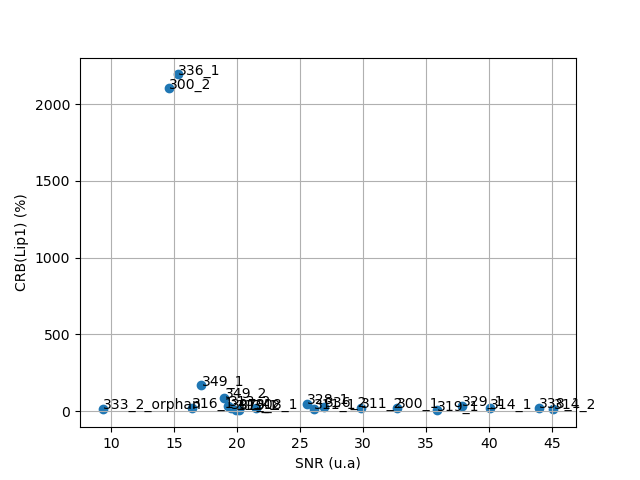

R = -0.36


<IPython.core.display.Javascript object>


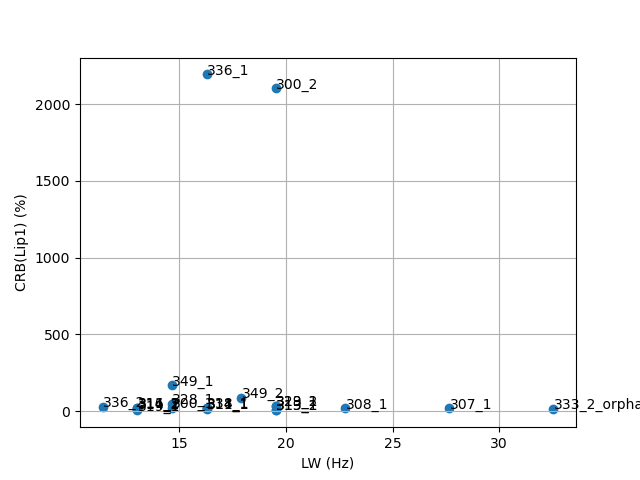

R = 0.00


<IPython.core.display.Javascript object>


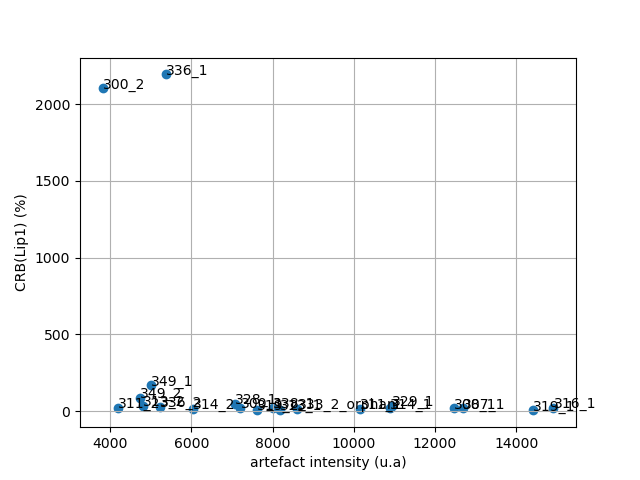

R = -0.37


<IPython.core.display.Javascript object>

R = -0.17


<IPython.core.display.Javascript object>

R = 0.02


<IPython.core.display.Javascript object>

R = -0.20


In [32]:
df = df_sc

for m in df["param_m"].unique():
    this_df = df.loc[(df["param_p"] == "cm") &
                     (df["param_m"] == m) &
                     (df["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                     (df["param_p_val_type"] == "err_prct") &
                     (df["reco_type"] == "optimal")]
    
    x = this_df["dataset_snr_final"]
    y = this_df["param_val"]
    # g = sns.JointGrid(x=x, y=y)
    # g.plot_joint(sns.regplot)
    # g.plot_marginals(sns.histplot, kde=True)
    # plt.xlabel("SNR (u.a)")
    # plt.ylabel("CRB(%s) (%%)" % m)
    # print("R = %.2f" % x.corr(y))
    
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel("SNR (u.a)")
    plt.ylabel("CRB(%s) (%%)" % m)
    plt.grid('on')
    print("R = %.2f" % x.corr(y))
    label_point(x, y, this_df["patient_study_id"], plt.gca())

    x = this_df["dataset_lw"]
    y = this_df["param_val"]
    # g = sns.JointGrid(x=x, y=y)
    # g.plot_joint(sns.regplot)
    # g.plot_marginals(sns.histplot, kde=True)
    # plt.xlabel("LW (Hz)")
    # plt.ylabel("CRB(%s) (%%)" % m)
    # print("R = %.2f" % x.corr(y))
    
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel("LW (Hz)")
    plt.ylabel("CRB(%s) (%%)" % m)
    plt.grid('on')
    print("R = %.2f" % x.corr(y))
    label_point(x, y, this_df["patient_study_id"], plt.gca())
    
    x = this_df["dataset_artefact_signal"]
    y = this_df["param_val"]
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel("artefact intensity (u.a)")
    plt.ylabel("CRB(%s) (%%)" % m)
    plt.grid('on')
    print("R = %.2f" % x.corr(y))
    label_point(x, y, this_df["patient_study_id"], plt.gca())


So in theory, CRBs increase when SNR decreases and when LW increases. It is the case here, most of the time. Just not very significant...

# Annotated SNR & LW

In [33]:
df = df_sc

threshold_snr_test = 15
threshold_lw_test = 25

df = df.loc[df["reco_type"] == "optimal"]
x = df["dataset_lw"]
y = df["dataset_snr_final"]

plt.figure()
plt.clf()
plt.scatter(x, y)
plt.xlabel("LW (Hz)")
plt.ylabel("SNR (u.a)")
print("R = %.2f" % x.corr(y))

df = df.drop_duplicates("patient_study_id")
x = df["dataset_lw"]
y = df["dataset_snr_final"]
label_point(x, y, df["patient_study_id"], plt.gca())

plt.axvline(threshold_lw_test)
plt.axhline(threshold_snr_test)
plt.grid('on')


<IPython.core.display.Javascript object>

R = -0.48


To remove the bad scans mentioned above, SNR and LW threshold of 16 and 25 should really help

# Annotated R2 & FQN

<IPython.core.display.Javascript object>


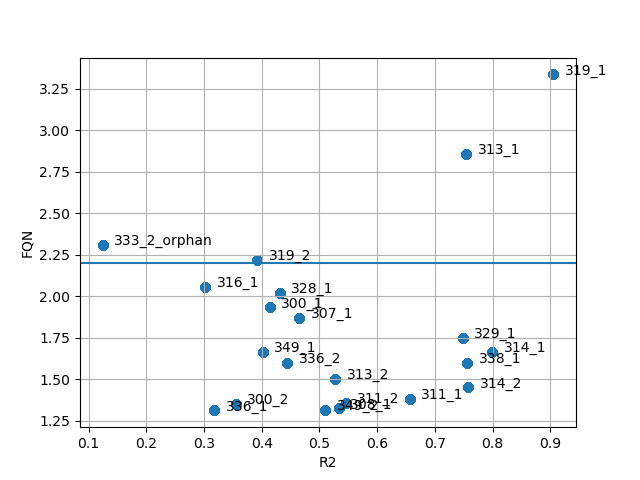

R = 0.21


In [34]:
df = df_sc

threshold_fqn_test = 2.2

df = df.loc[df["reco_type"] == "optimal"]
x = df["fit_results_optim_result_rsq_f"]
y = df["fit_results_optim_result_fqn"]

plt.figure()
plt.clf()
plt.scatter(x, y)
plt.xlabel("R2")
plt.ylabel("FQN")
print("R = %.2f" % x.corr(y))

df = df.drop_duplicates("patient_study_id")
x = df["fit_results_optim_result_rsq_f"]
y = df["fit_results_optim_result_fqn"]
label_point(x, y, df["patient_study_id"], plt.gca())

plt.axhline(threshold_fqn_test)
plt.grid('on')


# Adjust SNR, LW and FQN thresholds vs. results variability
To justify our choice in threshold. Can I see obvious value to choose when looking at STD or COV of metabolite estimations over the group? 

<IPython.core.display.Javascript object>


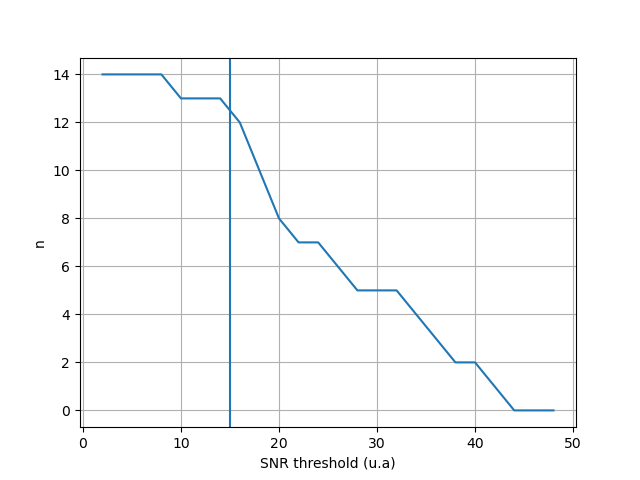

<IPython.core.display.Javascript object>


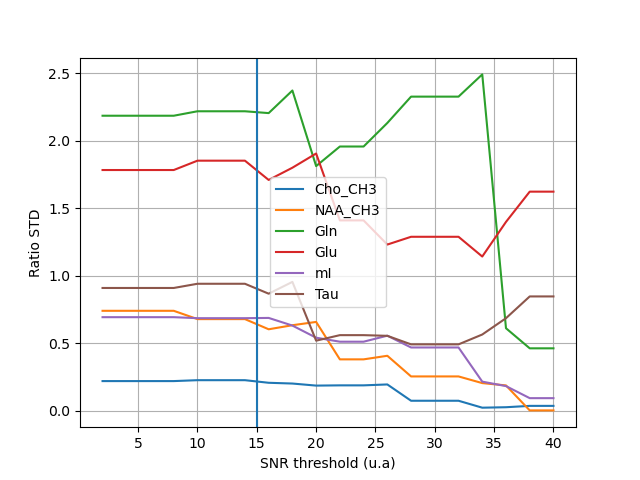

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


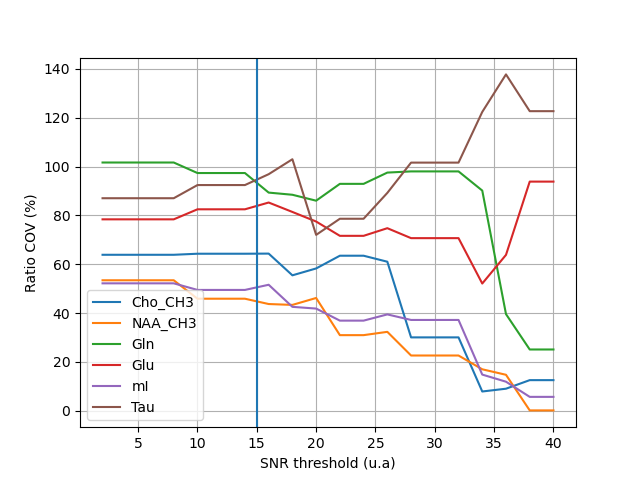

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


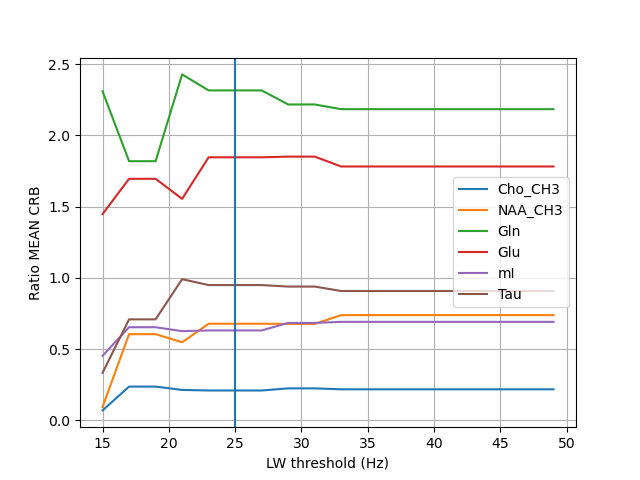

<IPython.core.display.Javascript object>


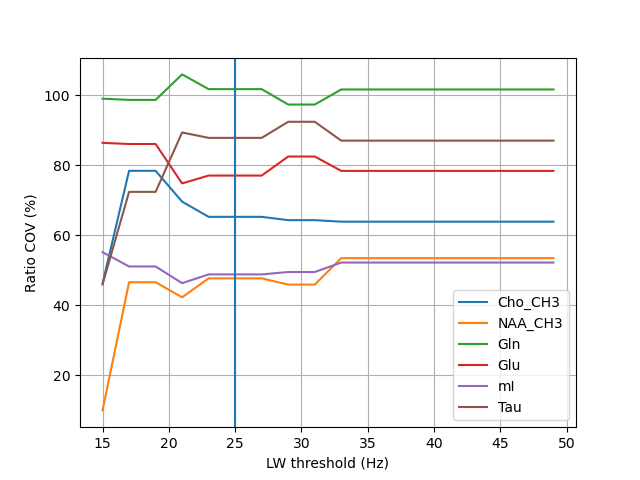

<IPython.core.display.Javascript object>


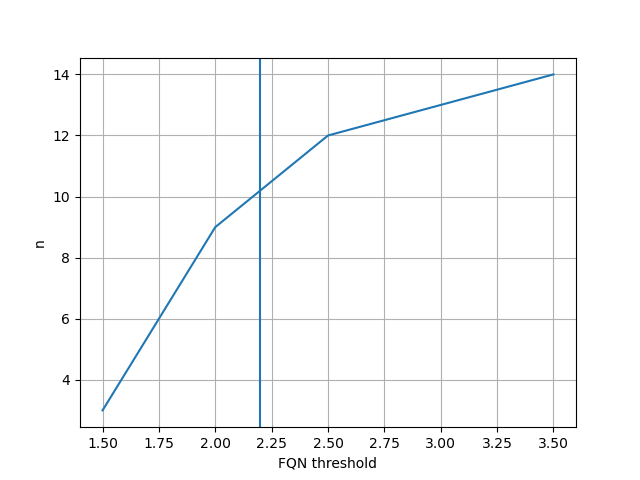

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


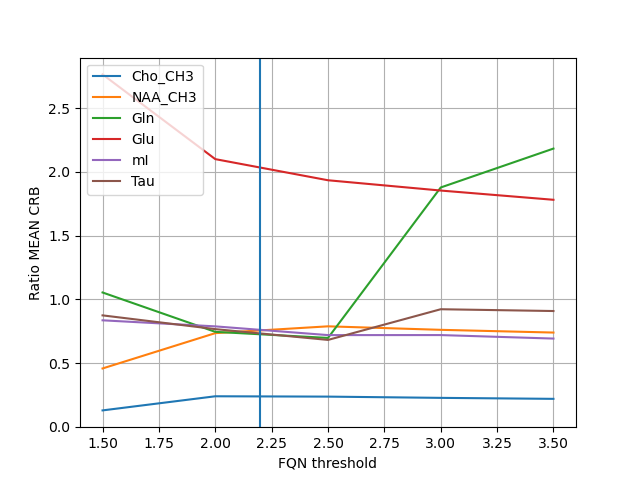

<IPython.core.display.Javascript object>

In [35]:
def filter_by_snr_lw_fqn(this_df, snr_min, lw_max, fqn_max):
    this_df = this_df.loc[   (this_df["reco_type"] == "optimal") &
                            (this_df["study"] == 1) &
                            (this_df["dataset_snr_final"] > snr_min) &
                            (this_df["dataset_lw"] < lw_max) &
                            (this_df["fit_results_optim_result_fqn"] < fqn_max)]

    metabolites_to_hide_list = ["Cho_CH2",
                                "Cr_CH3",
                                "Cr_CH2",
                                "NAA_CH2", 
                                "Lip1", "Lip2", "Water"]

    params_to_show_list = ['params_area_pnorm_T2norm_ratio_cre_obj', 
                           'params_fit_T2norm_ratio_cre_obj']

    this_df2 = this_df.loc[(this_df["param_p"] == "cm") &
                        (this_df["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                        (this_df["param_p_val_type"] == "val") &
                        ~(this_df["param_m"].isin(metabolites_to_hide_list))]
    
    res_n_subjects = len(this_df2["patient_study_id"].unique())
    res_meta_names_list = ["Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]
    res_ratio_val_std = []
    res_ratio_err_prct_mean = []
    res_ratio_cov = []
    
    for m in res_meta_names_list:

        this_df_fit_ratio = this_df.loc[(this_df["param_m"] == m) &
                         (this_df["param_p"] == "cm") &
                         (this_df["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (this_df["param_p_val_type"] == "val")]
        res_ratio_val_std.append(this_df_fit_ratio["param_val"].std())

        this_df_fit_ratio_err = this_df.loc[(this_df["param_m"] == m) &
                         (this_df["param_p"] == "cm") &
                         (this_df["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (this_df["param_p_val_type"] == "err_prct")]
        res_ratio_err_prct_mean.append(this_df_fit_ratio["param_val"].std())
        
        res_ratio_cov.append(this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0) 

    return(res_n_subjects, res_meta_names_list, res_ratio_val_std, res_ratio_err_prct_mean, res_ratio_cov)

df = df_sc

threshold_snr_list = np.arange(2, 50, 2)
threshold_n_list = []
threshold_val_std_list = []
threshold_err_prct_mean_list = []
threshold_cov_list = []

for this_threshold_snr in threshold_snr_list:
    res_n_subjects, res_meta_names_list, res_ratio_val_std, res_ratio_err_prct_mean, res_ratio_cov = filter_by_snr_lw_fqn(df, this_threshold_snr, 1000, 1000)
    threshold_n_list.append(res_n_subjects)
    threshold_val_std_list.append(res_ratio_val_std)
    threshold_err_prct_mean_list.append(res_ratio_err_prct_mean)
    threshold_cov_list.append(res_ratio_cov)

plt.figure()
plt.plot(threshold_snr_list, threshold_n_list)
plt.xlabel("SNR threshold (u.a)")
plt.ylabel("n")
plt.grid('on')
plt.axvline(threshold_snr_test)

plt.figure()
plt.plot(threshold_snr_list, threshold_val_std_list)
plt.xlabel("SNR threshold (u.a)")
plt.ylabel("Ratio STD")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_snr_test)

plt.figure()
plt.plot(threshold_snr_list, threshold_err_prct_mean_list)
plt.xlabel("SNR threshold (u.a)")
plt.ylabel("Ratio MEAN CRB")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_snr_test)

plt.figure()
plt.plot(threshold_snr_list, threshold_cov_list)
plt.xlabel("SNR threshold (u.a)")
plt.ylabel("Ratio COV (%)")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_snr_test)

# now by lw

threshold_lw_list = np.arange(5, 50, 2)
threshold_n_list = []
threshold_val_std_list = []
threshold_err_prct_mean_list = []
threshold_cov_list = []

for this_threshold_lw in threshold_lw_list:
    res_n_subjects, res_meta_names_list, res_ratio_val_std, res_ratio_err_prct_mean, res_ratio_cov = filter_by_snr_lw_fqn(df, 0, this_threshold_lw, 1000)
    threshold_n_list.append(res_n_subjects)
    threshold_val_std_list.append(res_ratio_val_std)
    threshold_err_prct_mean_list.append(res_ratio_err_prct_mean)
    threshold_cov_list.append(res_ratio_cov)

plt.figure()
plt.plot(threshold_lw_list, threshold_n_list)
plt.xlabel("LW threshold (Hz)")
plt.ylabel("n")
plt.grid('on')
plt.axvline(threshold_lw_test)

plt.figure()
plt.plot(threshold_lw_list, threshold_val_std_list)
plt.xlabel("LW threshold (Hz)")
plt.ylabel("Ratio STD")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_lw_test)

plt.figure()
plt.plot(threshold_lw_list, threshold_err_prct_mean_list)
plt.xlabel("LW threshold (Hz)")
plt.ylabel("Ratio MEAN CRB")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_lw_test)

plt.figure()
plt.plot(threshold_lw_list, threshold_cov_list)
plt.xlabel("LW threshold (Hz)")
plt.ylabel("Ratio COV (%)")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_lw_test)

# now by fqn

threshold_fqn_list = np.arange(1.5, 4, 0.5)
threshold_n_list = []
threshold_val_std_list = []
threshold_err_prct_mean_list = []
threshold_cov_list = []

for this_threshold_fqn in threshold_fqn_list:
    res_n_subjects, res_meta_names_list, res_ratio_val_std, res_ratio_err_prct_mean, res_ratio_cov = filter_by_snr_lw_fqn(df, 0, 1000, this_threshold_fqn)
    threshold_n_list.append(res_n_subjects)
    threshold_val_std_list.append(res_ratio_val_std)
    threshold_err_prct_mean_list.append(res_ratio_err_prct_mean)
    threshold_cov_list.append(res_ratio_cov)

plt.figure()
plt.plot(threshold_fqn_list, threshold_n_list)
plt.xlabel("FQN threshold")
plt.ylabel("n")
plt.grid('on')
plt.axvline(threshold_fqn_test)

plt.figure()
plt.plot(threshold_fqn_list, threshold_val_std_list)
plt.xlabel("FQN threshold")
plt.ylabel("Ratio STD")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_fqn_test)

plt.figure()
plt.plot(threshold_fqn_list, threshold_err_prct_mean_list)
plt.xlabel("FQN threshold")
plt.ylabel("Ratio MEAN CRB")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_fqn_test)

plt.figure()
plt.plot(threshold_fqn_list, threshold_cov_list)
plt.xlabel("FQN threshold")
plt.ylabel("Ratio COV (%)")
plt.legend(res_meta_names_list)
plt.grid('on')
plt.axvline(threshold_fqn_test)
    

# Adjust SNR, LW, FQN thresholds vs. quantification results
according to results (I know, not very ethical)

In [36]:
def run_p1_p2_stats(this_df, threshold_snr, threshold_lw, threshold_fqn, this_reco_type):

    # first, make the stats for P1
    df_filtered = this_df.loc[  (this_df["reco_type"] == this_reco_type) &
                                (this_df["dataset_snr_final"] > threshold_snr) &
                                (this_df["dataset_lw"] < threshold_lw) &
                                (this_df["fit_results_optim_result_fqn"] < threshold_fqn)]
    
    df_filtered_rej = this_df.loc[  (this_df["reco_type"] == this_reco_type) &
                                ((this_df["dataset_snr_final"] < threshold_snr) |
                                (this_df["dataset_lw"] > threshold_lw) |
                                (this_df["fit_results_optim_result_fqn"] > threshold_fqn))]

    # deal with orphans
    df_p1 = df_filtered.loc[(df_filtered["study"] == 1)]

    df_p2_orphan = df_filtered.loc[ (df_filtered["study"] == 2) &
                                    ~(df_filtered["patient"].isin(list(df_p1["patient"].unique()))) ]

    # changed to P1
    print("Number of P2 orphans fixed = %d" % len(df_p2_orphan["patient_study_id"].unique()))
    for this_index in list(df_p2_orphan.index):
        df_filtered.at[this_index, "study"] = 1
        df_filtered.at[this_index, "patient_study_id"] = df_filtered.at[this_index, "patient_study_id"] + "_orphan"

    
    # now deal with P1 stats only
    df_p1 = df_filtered.loc[(df_filtered["study"] == 1)]
        
    # txt output
    print("Number of P1 patients = %d" % len(df_p1["patient"].unique()))

    print("Metabolite".ljust(15) + " \t Area (SD) \t Fit (SD) \t raw CRB (med) \t ratio CRB (med) \t ratio CV (%)")
    for m in ["Cr_CH3", "Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:

        this_df_area = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "val")]

        this_df_fit_raw_err = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_obj") & 
                         (df_p1["param_p_val_type"] == "err")]  

        this_df_fit_ratio_err = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "err_prct")]  


        print("%s \t %.2f (%.2f) \t %.2f (%.2f) \t %06.2f \t\t %06.2f \t\t %06.2f" % 
              (m.ljust(15),
               this_df_area["param_val"].mean(),
               this_df_area["param_val"].std(),
               this_df_fit_ratio["param_val"].mean(),
               this_df_fit_ratio["param_val"].std(),
               this_df_fit_raw_err["param_val"].median(),
               this_df_fit_ratio_err["param_val"].median(),
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))

    # now deal with variability between P1 and P2
    df_p2 = df_filtered.loc[df_filtered["study"] == 2]

    df_p1 = df_filtered.loc[(df_filtered["patient"].isin(list(df_p2["patient"].unique()))) &
                            (df_filtered["study"] == 1)]

    df_p1_p2 = df_p1.append(df_p2)
    
    # txt output
    print()
    print("Number of P1 patients who did P2 = %d" % len(df_p1_p2["patient"].unique()))

    print("Metabolite".ljust(15) + "area CV (%) \t fit CV (%)")
    for m in ["Cr_CH3", "Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:
    
        this_df_area_ratio = df_p1_p2.loc[(df_p1_p2["param_m"] == m) &
                         (df_p1_p2["param_p"] == "cm") &
                         (df_p1_p2["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_p1_p2["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_p1_p2.loc[(df_p1_p2["param_m"] == m) &
                         (df_p1_p2["param_p"] == "cm") &
                         (df_p1_p2["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1_p2["param_p_val_type"] == "val")]

        print("%s %.2f \t\t %.2f" % 
              (m.ljust(15),
               this_df_area_ratio["param_val"].std() / this_df_area_ratio["param_val"].mean() * 100.0,
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))
        
    return(df_filtered, df_filtered_rej)

 
threshold_snr_test = 15
threshold_lw_test = 20
threshold_fqn_test = 1.9
_, _ = run_p1_p2_stats(df_sc, threshold_snr_test, threshold_lw_test, threshold_fqn_test, "optimal")


Number of P2 orphans fixed = 1
Number of P1 patients = 7
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (med) 	 ratio CRB (med) 	 ratio CV (%)
Cr_CH3          	 1.00 (0.00) 	 1.00 (0.00) 	 001.85 		 000.00 		 000.00
Cho_CH3         	 0.34 (0.13) 	 0.41 (0.22) 	 000.76 		 010.36 		 053.85
NAA_CH3         	 1.42 (0.26) 	 1.65 (0.62) 	 002.07 		 008.80 		 037.68
Gln             	 0.00 (0.00) 	 1.22 (0.65) 	 010.26 		 025.56 		 053.81
Glu             	 0.00 (0.00) 	 2.40 (1.60) 	 010.54 		 027.20 		 066.68
mI              	 0.00 (0.00) 	 1.41 (0.67) 	 004.96 		 015.99 		 047.53
Tau             	 0.00 (0.00) 	 0.91 (0.85) 	 008.71 		 040.08 		 093.63

Number of P1 patients who did P2 = 4
Metabolite     area CV (%) 	 fit CV (%)
Cr_CH3          0.00 		 0.00
Cho_CH3         42.49 		 66.91
NAA_CH3         16.58 		 42.69
Gln             nan 		 54.99
Glu             nan 		 80.85
mI              nan 		 64.78
Tau             nan 		 73.59


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


# Final stats and figs

## Height & Weight & BMI (included AND excluded)

In [37]:
df = df_sc.loc[df_sc["study"] == 1]

print("Mean weight = %.2fkgs +/-%.2f " % (df["dataset_raw_data__patient_weight"].mean(),
                                          df["dataset_raw_data__patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f " % (df["dataset_raw_data__patient_height"].mean(),
                                        df["dataset_raw_data__patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f " % (df["dataset_patient_bmi"].mean(), 
                                    df["dataset_patient_bmi"].std()))

sex_counts = df.groupby("dataset_raw_data__patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient"].nunique()))

Mean weight = 56.50kgs +/-13.89 
Mean height = 1.65m +/-0.12 
Mean BMI = 20.43 +/-2.72 
Sex = M(4) F(10)


## Final data filtering

In [38]:
threshold_snr_final = 15
threshold_lw_final = 25
threshold_fqn_final = 2.2
df_sc_final, df_sc_final_rej = run_p1_p2_stats(df_sc, threshold_snr_final, threshold_lw_final, threshold_fqn_final, "optimal")

Number of P2 orphans fixed = 1
Number of P1 patients = 11
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (med) 	 ratio CRB (med) 	 ratio CV (%)
Cr_CH3          	 1.00 (0.00) 	 1.00 (0.00) 	 001.78 		 000.00 		 000.00
Cho_CH3         	 0.29 (0.14) 	 0.34 (0.23) 	 000.73 		 010.86 		 066.72
NAA_CH3         	 1.45 (0.39) 	 1.56 (0.72) 	 002.07 		 008.80 		 045.87
Gln             	 0.00 (0.00) 	 1.33 (0.61) 	 010.02 		 021.65 		 045.55
Glu             	 0.00 (0.00) 	 2.49 (1.94) 	 010.54 		 023.62 		 077.62
mI              	 0.00 (0.00) 	 1.20 (0.62) 	 004.96 		 015.99 		 052.02
Tau             	 0.00 (0.00) 	 0.89 (0.68) 	 008.71 		 040.08 		 076.51

Number of P1 patients who did P2 = 4
Metabolite     area CV (%) 	 fit CV (%)
Cr_CH3          0.00 		 0.00
Cho_CH3         42.49 		 66.91
NAA_CH3         16.58 		 42.69
Gln             nan 		 54.99
Glu             nan 		 80.85
mI              nan 		 64.78
Tau             nan 		 73.59


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


In [39]:
print("---BEFORE FILTERING---")
n_patient_p1_before = len(df_sc.loc[(df_sc["study"] == 1)]["patient"].unique())

df_p2 = df_sc.loc[df_sc["study"] == 2]

df_p1 = df_sc.loc[(df_sc["patient"].isin(list(df_p2["patient"].unique()))) &
                    (df_sc["study"] == 1)]

df_p1_p2 = df_p1.append(df_p2)
n_patient_p1_p2_before = len(df_p1_p2["patient"].unique())
print("Number of P1 patients = %d" % n_patient_p1_before)
print("Number of P1 patients who did P2 = %d" % n_patient_p1_p2_before)

print("---FILTERING---")
n_patient_p1_after = len(df_sc_final.loc[(df_sc_final["study"] == 1)]["patient"].unique())
n_patient_p1_rej = n_patient_p1_before - n_patient_p1_after
n_patient_p1_rej_prct = (n_patient_p1_before - n_patient_p1_after) / n_patient_p1_before * 100.0
print("Number of P1 patients rejected = %d (%2.f %%)" % (n_patient_p1_rej, n_patient_p1_rej_prct))

print("---AFTER FILTERING---")
n_patient_p1_after = len(df_sc_final.loc[(df_sc_final["study"] == 1)]["patient"].unique())

df_p2 = df_sc_final.loc[df_sc_final["study"] == 2]

df_p1 = df_sc_final.loc[(df_sc_final["patient"].isin(list(df_p2["patient"].unique()))) &
                    (df_sc_final["study"] == 1)]

df_p1_p2 = df_p1.append(df_p2)
n_patient_p1_p2_after = len(df_p1_p2["patient"].unique())
print("Number of P1 patients = %d" % n_patient_p1_after)
print("Number of P1 patients who did P2 = %d" % n_patient_p1_p2_after)


---BEFORE FILTERING---
Number of P1 patients = 14
Number of P1 patients who did P2 = 7
---FILTERING---
Number of P1 patients rejected = 3 (21 %)
---AFTER FILTERING---
Number of P1 patients = 11
Number of P1 patients who did P2 = 4


In [40]:
# remove useless variables
clean_mem(dir(), ["df_sc", "df_sc_final", "df_sc_final_rej", "df_brain"])
df_sc.info()
df_sc_final.info()
df_brain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14742 entries, 887 to 50272
Columns: 4795 entries, fit_hash to reco_pipeline_job_list[8]_final_npts
dtypes: bool(436), datetime64[ns](30), float64(2410), int64(3), object(1916)
memory usage: 496.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3510 entries, 887 to 50272
Columns: 4795 entries, fit_hash to reco_pipeline_job_list[8]_final_npts
dtypes: bool(436), datetime64[ns](30), float64(2410), int64(3), object(1916)
memory usage: 118.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 263 to 14361
Columns: 3547 entries, fit_hash to param_p_val_type
dtypes: bool(436), datetime64[ns](18), float64(1579), int64(3), object(1511)
memory usage: 17.0+ MB


## Average voxel size

In [41]:
df_sc_final["Included"] = True
df_sc_final_rej["Included"] = False

df = pd.concat([df_sc_final, df_sc_final_rej]).drop_duplicates("patient_study_id")

print("* Voxel volume (cm3) = %.2f (%.2f)" % (df["dataset_voxel_vol_cm3"].mean(), 
                                              df["dataset_voxel_vol_cm3"].std()))

print("* Voxel X dimension (mm) = %.2f (%.2f)" % (df["dataset_voxel_size_X_mm"].mean(), 
                                              df["dataset_voxel_size_X_mm"].std()))
print("* Voxel Y dimension (mm) = %.2f (%.2f)" % (df["dataset_voxel_size_Y_mm"].mean(), 
                                              df["dataset_voxel_size_Y_mm"].std()))
print("* Voxel Z dimension (mm) = %.2f (%.2f)" % (df["dataset_voxel_size_Z_mm"].mean(), 
                                              df["dataset_voxel_size_Z_mm"].std()))

df["dataset_voxel_size_X_mm"]

* Voxel volume (cm3) = 0.95 (0.36)
* Voxel X dimension (mm) = 6.95 (1.36)
* Voxel Y dimension (mm) = 6.43 (0.93)
* Voxel Z dimension (mm) = 20.76 (2.79)


887      9.000000
901      6.000002
908      9.000000
922      7.999997
929      5.999998
943      6.000000
950      6.000001
957      6.000003
964      6.000000
978      6.000001
985      6.000001
992      6.000002
1006     6.000000
1020     6.000000
1027     6.000000
894      8.000003
915      7.999996
936     10.000004
971      6.000001
999      9.000000
1013     7.000000
Name: dataset_voxel_size_X_mm, dtype: float64

In [42]:
df["dataset_voxel_size_Y_mm"]

887     8.000000
901     6.000000
908     8.000002
922     7.999997
929     5.999998
943     5.999999
950     6.000000
957     6.000000
964     5.999999
978     6.000000
985     6.000000
992     6.000000
1006    5.999998
1020    5.999997
1027    5.999998
894     8.000000
915     6.000000
936     8.000003
971     6.000000
999     6.000000
1013    5.000001
Name: dataset_voxel_size_Y_mm, dtype: float64

In [43]:
df["dataset_voxel_size_Z_mm"]

887     20.000000
901     20.000005
908     20.000004
922     20.000000
929     20.000000
943     22.999995
950     30.000006
957     20.000009
964     19.999996
978     20.000005
985     20.000003
992     20.000005
1006    19.999995
1020    19.999991
1027    19.999994
894     20.000007
915     22.999989
936     25.000000
971     20.000003
999     20.000000
1013    15.000003
Name: dataset_voxel_size_Z_mm, dtype: float64

## CSDE
Chemical shift displacement errors?

In [44]:
print("* X dimension (%%/ppm) = %.2f" % df["dataset_csde_X"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df["dataset_csde_Y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df["dataset_csde_Z"].mean())

print("* For protocol(i)?")
print("* X dimension (%%/ppm) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_csde_X"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_csde_Y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_csde_Z"].mean())

print("* For protocol(ii)?")
print("* X dimension (%%/ppm) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_csde_X"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_csde_Y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_csde_Z"].mean())

df["dataset_csde_X"]

* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 13.53
* Z dimension (%/ppm) = 13.53
* For protocol(i)?
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 13.08
* Z dimension (%/ppm) = 13.08
* For protocol(ii)?
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 14.66
* Z dimension (%/ppm) = 14.66


887     8.741378
901     8.741320
908     8.741347
922     8.741352
929     8.741332
943     8.741340
950     8.741354
957     8.741341
964     8.741356
978     8.741342
985     8.741354
992     8.741334
1006    8.741349
1020    8.741349
1027    8.741342
894     8.741350
915     8.741359
936     8.741347
971     8.741354
999     8.741341
1013    8.741349
Name: dataset_csde_X, dtype: float64

In [45]:
df["dataset_csde_Y"]

887     13.374308
901     10.402170
908     16.346318
922     10.402209
929     10.699390
943     13.374250
950     11.888241
957     14.860279
964     11.888244
978     14.860281
985     14.117287
992     14.117254
1006    13.374264
1020    11.145220
1027    14.860281
894     11.888236
915     13.374280
936     17.832347
971     14.117286
999     17.832337
1013    13.374264
Name: dataset_csde_Y, dtype: float64

In [46]:
df["dataset_csde_Z"]

887     13.374308
901     10.402170
908     16.346318
922     10.402209
929     10.699390
943     13.374250
950     11.888241
957     14.860279
964     11.888244
978     14.860281
985     14.117287
992     14.117254
1006    13.374264
1020    11.145220
1027    14.860281
894     11.888236
915     13.374280
936     17.832347
971     14.117286
999     17.832337
1013    13.374264
Name: dataset_csde_Z, dtype: float64

## Average TE

In [47]:
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df["dataset_raw_data__sequence_te"].mean(), 
                                                 df["dataset_raw_data__sequence_te"].std(), 
                                                 df["dataset_raw_data__sequence_te"].min(), 
                                                 df["dataset_raw_data__sequence_te"].max()))

print("* For protocol(i)?")
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_raw_data__sequence_te"].mean(),
                                                 df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_raw_data__sequence_te"].std(),
                                                 df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_raw_data__sequence_te"].min(),
                                                 df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_raw_data__sequence_te"].max()))

print("* For protocol(ii)?")
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_raw_data__sequence_te"].mean(),
                                                df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_raw_data__sequence_te"].std(),
                                                df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_raw_data__sequence_te"].min(),
                                                df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_raw_data__sequence_te"].max()))


* TE (ms) = 46.20 (13.19) [21.16 - 90.00]
* For protocol(i)?
* TE (ms) = 51.44 (11.37) [41.68 - 90.00]
* For protocol(ii)?
* TE (ms) = 33.08 (6.73) [21.16 - 38.96]


## Min and average TR

In [48]:
print("* Min TR (ms) = %.2f" % df["dataset_raw_data__sequence_tr"].mean())

print("* For protocol(i)?")
print("* Min TR (ms) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] >=20]["dataset_raw_data__sequence_tr"].mean())

print("* For protocol(ii)?")
print("* Min TR (ms) = %.2f" % df.loc[df["dataset_raw_data__sequence_pulse_rfc_r"] <20]["dataset_raw_data__sequence_tr"].mean())


print("* Eff TR (s) = %.2f" % (df["dataset_acqtime_eff"] / df["dataset_raw_data__sequence_na"]).mean())


* Min TR (ms) = 4853.81
* For protocol(i)?
* Min TR (ms) = 4544.00
* For protocol(ii)?
* Min TR (ms) = 5628.33
* Eff TR (s) = 7.17


## Acquisition time

In [49]:
print("* Acquisition time (min) = %.2f" % (df["dataset_acqtime"].mean() / 60))
print("* Eff acquisition time (min) = %.2f" % (df["dataset_acqtime_eff"].mean() / 60))


* Acquisition time (min) = 9.67
* Eff acquisition time (min) = 13.55


## Average data rejection rate

In [50]:
print("* Data rejected (%%) = %.2f" % df["dataset_rejection_rate_prct"].mean())


* Data rejected (%) = 9.40


## Final SNR/FWHM gain with data rejection?

In [51]:
# calculate snr gain
df["snr_gain_thanks"] = (df.loc[df["reco_type"] == "optimal"]["dataset_raw_data__data_rejection[0]_Post-rejection_snr"]-df.loc[df["reco_type"] == "optimal"]["dataset_raw_data__data_rejection[0]_Pre-rejection_snr"]) / df.loc[df["reco_type"] == "optimal"]["dataset_raw_data__data_rejection[0]_Pre-rejection_snr"] * 100.0
df["lw_gain_thanks"] = df.loc[df["reco_type"] == "optimal"]["dataset_raw_data__data_rejection[0]_Post-rejection_lw"] - df.loc[df["reco_type"] == "optimal"]["dataset_raw_data__data_rejection[0]_Pre-rejection_lw"]

print("* SNR gain thanks to data rejection (%%) = %.2f" % (df["snr_gain_thanks"].mean()))
print("* FWHM gain thanks to data rejection (Hz) = %.2f" % (df["lw_gain_thanks"].mean()))


* SNR gain thanks to data rejection (%) = 3.40
* FWHM gain thanks to data rejection (Hz) = -0.23


## Final SNR_norm vs. BMI

In [52]:
this_df = df

this_df = this_df.rename(columns = {'dataset_snr_norm':'Normalized SNR (u.a)'})
this_df = this_df.rename(columns = {'dataset_patient_bmi':'Subject BMI'})
x = this_df["Subject BMI"]
y = this_df["Normalized SNR (u.a)"]

plt.figure()
g = sns.scatterplot(x="Subject BMI", y="Normalized SNR (u.a)",
                hue="dataset_raw_data_posY_mm", cmap=cm,
                style="Included", style_order=[True, False],
                s=150, data=this_df)

plt.grid(True)

norm = plt.Normalize(this_df['dataset_raw_data_posY_mm'].min(), this_df['dataset_raw_data_posY_mm'].max())
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
g.get_legend().remove()


cb = g.figure.colorbar(sm)
cb.set_label(label='Y voxel position (mm)')

plt.show()

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='k', linewidth=1)

print("R = %.2f" % x.corr(y))

plt.xlabel("Subject BMI (kg/m²)")

plt.savefig("./notebooks/figs/fig_snr_bmi.svg")

<IPython.core.display.Javascript object>

R = -0.60


## [FIG] SNR & LW & FQN
with rejection bounds

In [53]:
print("There is %d datasets accepted" % df_sc_final["patient_study_id"].nunique())
print("There is %d datasets rejected" % df_sc_final_rej["patient_study_id"].nunique())
print("Datasets rejected (%%) = %.2f" % (df_sc_final["patient_study_id"].nunique() / (df_sc_final["patient_study_id"].nunique() + df_sc_final_rej["patient_study_id"].nunique()) * 100))


There is 15 datasets accepted
There is 6 datasets rejected
Datasets rejected (%) = 71.43


Mean SNR = 27.79 (9.79)
Mean FWHM = 15.95 Hz (2.92)
Mean FQN = 1.60 (0.25)


<IPython.core.display.Javascript object>


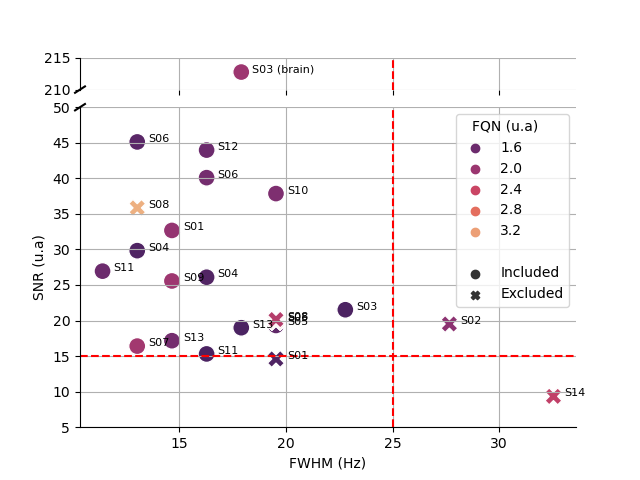

In [54]:
df_accepted = df_sc_final
df_rejected = df_sc_final_rej

df_accepted["Included"] = True
df_accepted[" "] = "Included"
df_rejected["Included"] = False
df_rejected[" "] = "Excluded"

print("Mean SNR = %.2f (%.2f)" % (df_accepted["dataset_snr_final"].mean(),
                                    df_accepted["dataset_snr_final"].std()))
print("Mean FWHM = %.2f Hz (%.2f)" % (df_accepted["dataset_lw"].mean(),
                                        df_accepted["dataset_lw"].std()))
print("Mean FQN = %.2f (%.2f)" % (df_accepted["fit_results_optim_result_fqn"].mean(), 
                                    df_accepted["fit_results_optim_result_fqn"].std()))

# compare with brain 
df_justto_brain = df_brain.loc[ (df_brain["dataset_snr_final"] > 100) &
                                (df_brain["fit_results_optim_result_fqn"] < 3)]

df_justto_brain["Included"] = True
df_justto_brain[" "] = "Included"
df_justto_brain["patient_study_id"] = df_justto_brain["patient_study_id"] + "_brain"
df_justto_brain["patient_study_id_pretty"] = df_justto_brain["patient_study_id_pretty"].str.replace("P1", "brain")
df_justto_brain["patient_pretty"] = df_justto_brain["patient_pretty"] + " (brain)"

this_df = pd.concat([df_accepted, df_rejected, df_justto_brain])

this_df = this_df.rename(columns = {'dataset_snr_final':'SNR (u.a)'})
this_df = this_df.rename(columns = {'dataset_lw':'FWHM (Hz)'})
this_df = this_df.rename(columns = {'fit_results_optim_result_fqn':'FQN (u.a)'})

# broken axis scatter plot
cm = sns.color_palette("flare_r", as_cmap=True)
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True,
                                      gridspec_kw={'hspace':0.10, 'height_ratios':[1, 10]})
g = sns.scatterplot(x="FWHM (Hz)", y="SNR (u.a)",
                hue="FQN (u.a)", palette=cm,
                style=" ", style_order=["Included", "Excluded"],
                s=150, data=this_df, ax=ax_top, legend=False)
ax_top.grid(True)
ax_top.axhline(threshold_snr_final, color='r', linestyle='--')
ax_top.axvline(threshold_lw_final, color='r', linestyle='--')

this_df_annot = this_df.loc[(this_df["SNR (u.a)"] > 200)].drop_duplicates("patient_study_id")
label_point(this_df_annot["FWHM (Hz)"], this_df_annot["SNR (u.a)"], this_df_annot["patient_pretty"],
            ax_top, 8, 0.5, 0)

g = sns.scatterplot(x="FWHM (Hz)", y="SNR (u.a)",
                hue="FQN (u.a)", palette=cm,
                style=" ", style_order=["Included", "Excluded"],
                s=150, data=this_df, ax=ax_bottom)
ax_bottom.grid(True)
ax_bottom.axhline(threshold_snr_final, color='r', linestyle='--')
ax_bottom.axvline(threshold_lw_final, color='r', linestyle='--')

this_df_annot = this_df.loc[(this_df["SNR (u.a)"] < 200)].drop_duplicates("patient_study_id")
label_point(this_df_annot["FWHM (Hz)"], this_df_annot["SNR (u.a)"], this_df_annot["patient_pretty"],
            ax_bottom, 8, 0.5, 0)

ax_top.set_ylim([210, 215])
ax_top.set_ylabel("")
ax_bottom.set_ylim(5, 50)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

# draw the small break sign
ax = ax_top
d = .01
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d*10, +d*10), **kwargs)
ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.savefig("./notebooks/figs/fig_snr_lw.svg")

## Were the rejected datasets from curvy subjects ? 

In [55]:
plt.figure()
g = sns.boxplot(x="Included", y="dataset_curvy_cord", data=this_df)
plt.grid('on')
this_df.drop_duplicates("patient_study_id")[["patient_study_id", "dataset_curvy_cord", "Included"]]

<IPython.core.display.Javascript object>

patient_study_id  dataset_curvy_cord  Included
887             300_1                 1.0      True
901             308_1                 3.0      True
908             311_1                 2.0      True
922             314_1                 2.0      True
929             316_1                 2.0      True
943             328_1                 1.0      True
950             329_1                 1.0      True
957             336_1                 1.0      True
964             338_1                 1.0      True
978             349_1                 2.0      True
985             311_2                 1.0      True
992             336_2                 1.0      True
1006     313_2_orphan                 1.0      True
1020            314_2                 1.0      True
1027            349_2                 3.0      True
894             307_1                 1.0     False
915             313_1                 1.0     False
936             319_1                 1.0     False
971             300_2                 1.0     False
999             319_2                 1.0     False
1013     333_2_orphan                 NaN     False
277       308_1_brain                 NaN      True

## Did the rejected datasets suffer with the 5ppm artefact?

<IPython.core.display.Javascript object>


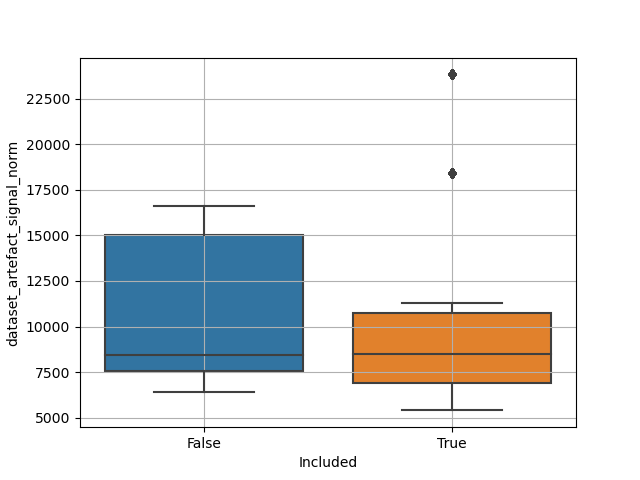

In [56]:
plt.figure()
g = sns.boxplot(x="Included", y="dataset_artefact_signal_norm", data=this_df)
plt.grid('on')

<IPython.core.display.Javascript object>


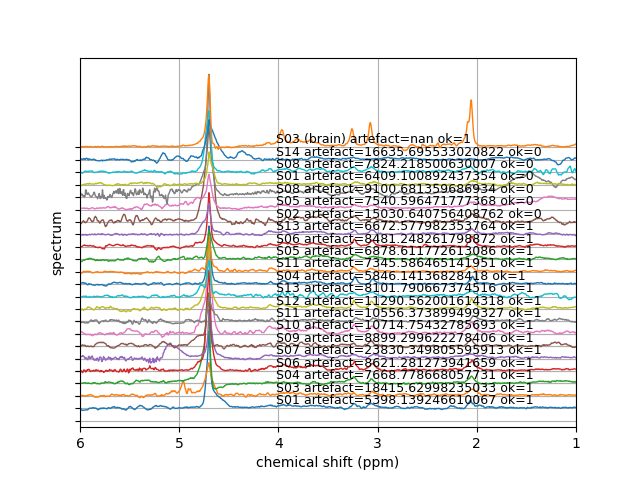

In [57]:
this_df2 = this_df.drop_duplicates("patient_study_id")

for this_index, this_row in this_df2.iterrows():
    this_df2.loc[this_index, "patient_pretty"] = this_row["patient_pretty"] + " artefact=" + str(this_row["dataset_artefact_signal_norm"]) + " ok=" + str(int(this_row["Included"]))

k = 0
label_x = 4 #ppm
for this_index, this_row in this_df2.iterrows():
    s = this_row["dataset_raw_data_obj"]
    if(s is None):
        s = this_row["dataset_dcm_data_obj"]
    
    s.set_display_offset(10000.0 * k)
    last_fig = s.display_spectrum_1d(10000)
    
    # add some x/y for annotation
    this_df2.at[this_index, "spectrum_label_x"] = label_x
    this_df2.at[this_index, "spectrum_label_y"] = 10000.0 * k
    
    # iterate
    k += 1

label_point(this_df2["spectrum_label_x"], this_df2["spectrum_label_y"], this_df2["patient_pretty"], plt.gca(), 9, 0, 3500)
ax = last_fig.axes
ax[0].set(yticklabels=[])
ax[0].get_legend().remove()

## Height & Weight & BMI (included only)

In [58]:
print("--- INCLUDED --- ")

df = df_sc_final.loc[df_sc_final["study"] == 1]

print("Mean weight = %.2fkgs +/-%.2f " % (df["dataset_raw_data__patient_weight"].mean(),
                                          df["dataset_raw_data__patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f " % (df["dataset_raw_data__patient_height"].mean(),
                                        df["dataset_raw_data__patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f " % (df["dataset_patient_bmi"].mean(), 
                                    df["dataset_patient_bmi"].std()))

sex_counts = df.groupby("dataset_raw_data__patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient"].nunique()))

print("--- REJECTED --- ")

df = df_sc_final_rej

print("Mean weight = %.2fkgs +/-%.2f " % (df["dataset_raw_data__patient_weight"].mean(),
                                          df["dataset_raw_data__patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f " % (df["dataset_raw_data__patient_height"].mean(),
                                        df["dataset_raw_data__patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f " % (df["dataset_patient_bmi"].mean(), 
                                    df["dataset_patient_bmi"].std()))

sex_counts = df.groupby("dataset_raw_data__patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient"].nunique()))

--- INCLUDED --- 
Mean weight = 55.09kgs +/-13.47 
Mean height = 1.64m +/-0.12 
Mean BMI = 20.02 +/-2.60 
Sex = M(3) F(8)
--- REJECTED --- 
Mean weight = 65.67kgs +/-14.30 
Mean height = 1.70m +/-0.12 
Mean BMI = 22.39 +/-2.12 
Sex = M(2) F(3)


## [FIG] Spectra gallery

<IPython.core.display.Javascript object>


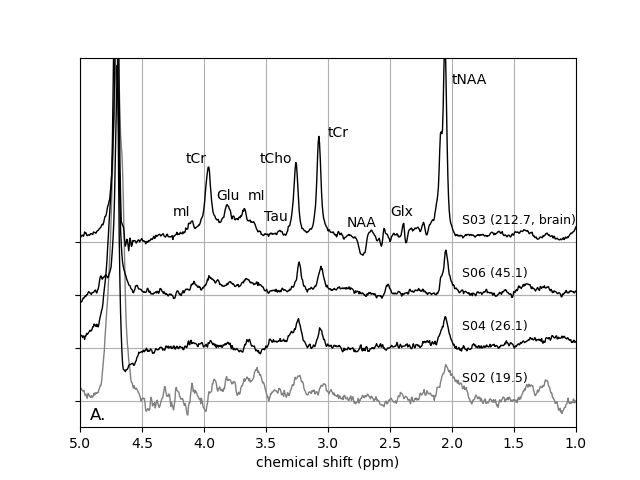

Text(3.9, 38000, 'Glu')

In [59]:
# compare with brain 
df_justto_brain = df_brain.loc[ (df_brain["dataset_snr_final"] > 100) &
                                (df_brain["fit_results_optim_result_fqn"] < 3)]
df_justto_brain["patient_study_id"] = df_justto_brain["patient_study_id"] + "_brain"
df_justto_brain["patient_study_id_pretty"] = df_justto_brain["patient_study_id_pretty"].str.replace("P1", "brain")
df_justto_brain["patient_pretty"] = df_justto_brain["patient_pretty"] + " (%.1f, brain)" % df_justto_brain.iloc[0]["dataset_snr_final"]

this_df_sc = df_sc.drop_duplicates("patient_study_id")
for this_index, this_row in this_df_sc.iterrows():
    this_df_sc.loc[this_index, "patient_pretty"] = this_row["patient_pretty"] + " (%.1f)" % this_row["dataset_snr_final"]

this_df = pd.concat([this_df_sc, df_justto_brain])
this_df = this_df.drop_duplicates("patient_study_id")
this_df = this_df.loc[this_df["patient_study_id"].isin(["308_1_brain", "314_2", "311_1", "307_1"])]
this_df = this_df.sort_values(by="dataset_snr_final")

k = 0
label_x = 1.9 #ppm
for this_index, this_row in this_df.iterrows():
    s = this_row["dataset_raw_data_obj"]
    if(s is None):
        s = this_row["dataset_dcm_data_obj"]
    
    s.set_display_offset(10000.0 * k)
    last_fig = s.display_spectrum_1d(1000)
    
    # add some x/y for annotation
    this_df.at[this_index, "spectrum_label_x"] = label_x
    this_df.at[this_index, "spectrum_label_y"] = 10000.0 * k
    
    # iterate
    k += 1

label_point(this_df["spectrum_label_x"], this_df["spectrum_label_y"], this_df["patient_pretty"], plt.gca(), 9, 0, 3500)

ax = last_fig.axes
ax[0].set(yticklabels=[])
ax[0].get_legend().remove()
plt.ylabel("")

for l in last_fig.axes[0].get_lines():
    l.set_color('black')

# last one in grey to show it is rejected
last_fig.axes[0].get_lines()[0].set_color('grey')
    
plt.xlim([5, 1])
yts = plt.yticks()
plt.yticks(yts[0][0:-4])
plt.ylim([-5000, 65000])

# add metabolites labels
plt.text(2, 60000, "tNAA")
plt.text(2.5, 35000, "Glx")
plt.text(2.85, 33000, "NAA")
plt.text(3, 50000, "tCr")
plt.text(3.55, 45000, "tCho")
plt.text(3.52, 34000, "Tau")
plt.text(4.15, 45000, "tCr")
plt.text(4.25, 35000, "mI")
plt.text(3.65, 38000, "mI")
plt.text(3.9, 38000, "Glu")



<IPython.core.display.Javascript object>


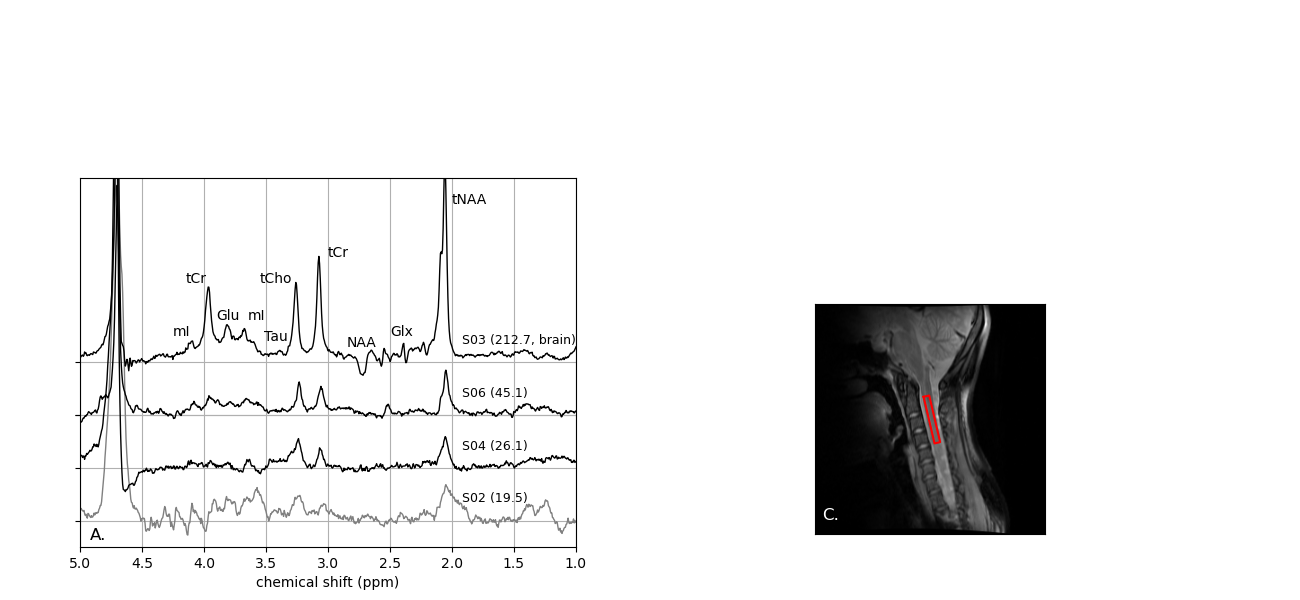

314_2
S06 (45.1)


Text(7.18, 240.14, 'C.')

In [60]:
# get previous fig and paste it here
new_fig = plt.figure(figsize=(13,6))
new_fig.subplots_adjust(wspace=0.01, hspace=0.01)

fig = plt.figure(1000)
ax_previous_fig = fig.axes[0]

ax_previous_fig.figure=new_fig
new_fig.axes.append(ax_previous_fig)
new_fig.add_axes(ax_previous_fig)

dummy = new_fig.add_subplot(1,3,(1,2))
ax_previous_fig.set_position(dummy.get_position())
dummy.remove()

xlim = ax_previous_fig.get_xlim()
ylim = ax_previous_fig.get_ylim()
ax_previous_fig.text(xlim[0] - (xlim[0]-xlim[1])*0.02, 
                     ylim[0] + (ylim[1]-ylim[0])*0.02, 
                    "A.",
                    fontsize=12)

# add a nice anatomy for spinal cord

t2w = suspect.image.load_dicom_volume("/home/tangir/crmbm/acq/314-yt-p2-moelle/20200625/01_0005_t2-tse-sag-2d-10sl-p2-trig-s4-nd/original-primary-m-norm-nd_e01_0001.dcm")

ind_patient = 2
pcg = this_df["dataset_dcm_data_obj"].iloc[ind_patient]
print(this_df["patient_study_id"].iloc[ind_patient])
print(this_df["patient_pretty"].iloc[ind_patient])

pcg_centre = pcg.to_scanner(0, 0, 0)
pcg_centre_index = t2w.from_scanner(*pcg_centre).round().astype(int)

corner_coords_pcg = [[0, -0.4, -1],
                     [0, -0.4, 1],
                     [0, 0.4, 1],
                     [0, 0.4, -1],
                     [0, -0.4, -1]]
corner_coords = np.array([t2w.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])


ax = new_fig.add_subplot(2,2,4)
ax.imshow(t2w[pcg_centre_index[2]], cmap=plt.cm.gray)
ax.plot(corner_coords[:, 0], corner_coords[:, 1], 'red')
ax.set_xticks([])
ax.set_yticks([])
new_fig.subplots_adjust(wspace=0.1, hspace=0.01)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] - (xlim[0]-xlim[1])*0.03, 
        ylim[0] + (ylim[1]-ylim[0])*0.06, 
        "C.",
        fontsize=12, color="white")

In [61]:
# add a nice anatomy for brain

t1w = suspect.image.load_dicom_volume("/home/tangir/crmbm/acq/347-re-p1-moelle/20200123/01_0009_mp2rage-wip900-sag-0-6iso-p3-uni-den/original-primary-m-nd-uni_e01_0001.dcm")

pcg = reco.MRSData2("/home/tangir/crmbm/acq_twix/347-re-p1-moelle/meas_MID228_slaser_R_N=10_2_longTE_SNR+++_FID50587.dat")

pcg_centre = pcg.to_scanner(0, 0, 0)
pcg_centre_index_brain = t1w.from_scanner(*pcg_centre).round().astype(int)

corner_coords_pcg = [[0, -0.75, -0.75],
                     [0, -0.75,  0.75],
                     [0, 0.75, 0.75],
                     [0, 0.75, -0.75],
                     [0, -0.75, -0.75]]
corner_coords = np.array([t1w.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])

ax = new_fig.add_subplot(2,2,2)
img_tmp = t1w[:, pcg_centre_index_brain[1], :].T
img_tmp = np.concatenate((np.zeros([402, int((402-256)/2)]), img_tmp), axis=1)
img_tmp = np.concatenate((img_tmp, np.zeros([402, int((402-256)/2)])), axis=1)

ax.imshow(img_tmp, cmap=plt.cm.gray)
ax.plot(corner_coords[:, 1]+int((402-256)/2), corner_coords[:, 0], 'red')
ax.set_xticks([])
ax.set_yticks([])
new_fig.subplots_adjust(wspace=0.1, hspace=0.01)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] - (xlim[0]-xlim[1])*0.03, 
        ylim[0] + (ylim[1]-ylim[0])*0.06, 
        "B.",
        fontsize=12, color="white")


new_fig.savefig("./notebooks/figs/fig_spectra.svg")

(INFO)  reco.py.__new__: reading data file...
(INFO)  reco.py.__new__: /home/tangir/crmbm/acq_twix/347-re-p1-moelle/meas_MID228_slaser_R_N=10_2_longTE_SNR+++_FID50587.dat
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 48
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 34
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 39
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 37
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at po

## [FIG] Fit example
with the best fit we have :)

In [62]:
import mrs.fit as fit

this_df = df_sc_final

#this_df = df.loc[df["fit_results_optim_result_rsq_f"] == df["fit_results_optim_result_rsq_f"].max()]
this_df = this_df.drop_duplicates("patient_study_id")
preferred_psi_list = ["314_1"]

for this_index, this_row in this_df.iterrows():
    if(this_row["patient_study_id"] in preferred_psi_list):
        s_data = this_row["dataset_raw_data_obj"]
        s_data = s_data.correct_water_removal_1d(8, [4.5, 6], False)

        # fit params
        p_fit = this_row["params_fit_obj"]

        # PRESS seq
        seq = sim.mrs_seq_press(s_data.sequence.te, s_data.sequence.tr, s_data.sequence.na, 
                                s_data.sequence.ds, s_data.sequence.nuclei, 
                                s_data.sequence.npts, s_data.sequence.voxel_size, 
                                s_data.sequence.fs, s_data.sequence.f0)

        seq.initialize()

        print(this_row["patient_study_id"] + " R(t/f) = %.2f/%.2f FQN = %.1f" % (this_row["fit_results_optim_result_rsq_t"],
                                                                                this_row["fit_results_optim_result_rsq_f"],
                                                                                this_row["fit_results_optim_result_fqn"]))


removing residual water peak with HSVD: ██████████████████████████████ done.


(INFO)  metabolite_basis_set.initialize: initializing metabolite database...
(INFO)  metabolite_basis_set._read_xls_file: reading metabolite basis set from XLS file...
(INFO)  mrs_seq_press.initialize: initializing sequence using pyGAMMA...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Ala/Ala]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Asc/Asc]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Asp/Asp]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho_CH3/Cho_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho_CH2/Cho_CH2]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cr_CH3/Cr_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cr_CH2/Cr_CH2]...
(INFO)  mrs_seq_press._c

314_1 R(t/f) = 0.82/0.80 FQN = 1.7


In [63]:
fig = plt.figure()
ax = fig.subplots()
fit.disp_fit(ax, s_data, p_fit, seq, True, True, None, False, [1, 5])

fig.savefig("./notebooks/figs/fig_fit.svg")  

<IPython.core.display.Javascript object>

## [FIG] Data rejection
* Amount of individual scans rejected
* Show snr and linewidth relative improvement
* Show how many subjects included w/o data rej and data rea
* Need to conclude on some ideal scan time...

In [64]:
df = df_sc_final.drop_duplicates("patient_study_id")

print("* Data rejection (%%) = %.2f (%.2f)" % (df["dataset_rejection_rate_prct"].mean(), 
                                                df["dataset_rejection_rate_prct"].std()) )

df[["patient_study_id", "dataset_rejection_rate_prct", "dataset_snr_final", "dataset_legend"]]


* Data rejection (%) = 7.92 (5.20)


patient_study_id  dataset_rejection_rate_prct  dataset_snr_final  \
887             300_1                    16.406250          32.669522   
901             308_1                    14.062500          21.518433   
908             311_1                    17.968750          26.090641   
922             314_1                     5.468750          40.093496   
929             316_1                     2.083333          16.404951   
943             328_1                    10.156250          25.563384   
950             329_1                    13.281250          37.852985   
957             336_1                     3.125000          15.304735   
964             338_1                     5.468750          43.968554   
978             349_1                     4.166667          17.164850   
985             311_2                     3.125000          29.827799   
992             336_2                     4.687500          26.942746   
1006     313_2_orphan                     8.593750          19.306907   
1020            314_2                     4.687500          45.115725   
1027            349_2                     5.468750          18.989690   

                     dataset_legend  
887         #1 sLASER R:N=25:1 trig  
901        #0 sLASER 20:1 resp trig  
908                  #0 sLASER 20:1  
922                  #0 sLASER 20:1  
929                   #1 sLASER 5:5  
943                  #0 sLASER 20:1  
950                  #0 sLASER 20:1  
957                  #0 sLASER 20:1  
964               #0 sLASER 20:1 WS  
978   #0 sLASER 10:2 (REF with OVS)  
985      #0 sLASER 20/1 NA=128 trig  
992      #0 sLASER 20/1 NA=128 trig  
1006                 #0 sLASER 20/1  
1020          #0 sLASER 20/1 NA=128  
1027          #0 sLASER 10/2 NA=128

In [65]:
# find which rejection method was used the most
df = df_sc_final.drop_duplicates("patient_study_id")

plt.figure()
df["dataset_best_rejection_method"] = df["dataset_raw_data__data_rejection[0]_Automatic data rejection methods_Best method"].astype(str)
df.groupby("dataset_best_rejection_method")["patient_study_id"].nunique().plot.pie(autopct="%.1f%%")

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='patient_study_id'>

In [66]:
df_sc_final_all_reco = df_sc.loc[  (df_sc["dataset_snr_final"] > threshold_snr_final) &
                            (df_sc["dataset_lw"] < threshold_lw_final) &
                            (df_sc["fit_results_optim_result_fqn"] < threshold_fqn_final)]

plt.figure()
g = sns.boxplot(x="reco_type", y="dataset_snr_norm", data=df_sc_final_all_reco)
plt.grid('on')

plt.figure()
g = sns.boxplot(x="reco_type", y="dataset_lw", data=df_sc_final_all_reco)
plt.grid('on')

print("n scans inluded vs. reco_type:")
print("* optimal n = %d" % df_sc_final_all_reco.loc[df_sc_final_all_reco["reco_type"] == "optimal"]["patient_study_id"].nunique())
print("* no_data_rejection n = %d" % df_sc_final_all_reco.loc[df_sc_final_all_reco["reco_type"] == "no_data_rejection"]["patient_study_id"].nunique())
print("* no_data_rejection_no_realignement n = %d" % df_sc_final_all_reco.loc[df_sc_final_all_reco["reco_type"] == "no_data_rejection_no_realignement"]["patient_study_id"].nunique())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

n scans inluded vs. reco_type:
* optimal n = 15
* no_data_rejection n = 15
* no_data_rejection_no_realignement n = 13


The average SNR and LW don't show much

<IPython.core.display.Javascript object>


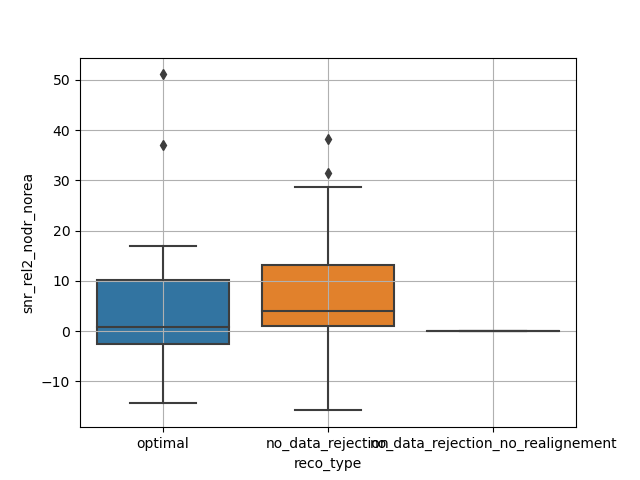

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reco method 	 SNR gain (%) 	 LW change (Hz) 	 FQN change
optimal 	 5.36 (15.48) 	 -4.73 (4.96) 	 -0.03 (0.25)
rea only 	 7.24 (13.52) 	 -4.50 (5.20) 	 -0.03 (0.27)
nothing 	 0.00 (0.00) 	 0.00 (0.00) 	 0.00 (0.00)


In [67]:
df = df_sc.loc[  (df_sc["dataset_snr_final"] > threshold_snr_final) &
                            (df_sc["dataset_lw"] < threshold_lw_final) &
                            (df_sc["fit_results_optim_result_fqn"] < threshold_fqn_final)]

df = df_sc.drop_duplicates(["patient_study_id", "reco_type"])



df2 = pd.DataFrame(columns=df.columns)
for this_index, this_row in df.iterrows():
    # find original snr
    orig_snr_serie = df.loc[(df["patient_study_id"] == this_row["patient_study_id"]) &
                      (df["reco_type"] == "no_data_rejection_no_realignement")]["dataset_snr_final"]
    
    if(not orig_snr_serie.empty):
        orig_snr=orig_snr_serie.iloc[0]

        # set rel snr
        #df.at[this_index, "snr_rel2_nodr_norea"] = this_row["dataset_snr_final"] / orig_snr * 100.0
        this_row["snr_rel2_nodr_norea"] = (this_row["dataset_snr_final"] - orig_snr) / orig_snr * 100.0

        # find original lw
        orig_lw = df.loc[(df["patient_study_id"] == this_row["patient_study_id"]) &
                          (df["reco_type"] == "no_data_rejection_no_realignement")]["dataset_lw"].iloc[0]

        # set rel snr
        #df.at[this_index, "lw_rel2_nodr_norea"] = this_row["dataset_lw"] - orig_lw
        this_row["lw_rel2_nodr_norea"] = this_row["dataset_lw"] - orig_lw
  
        # find original fqn
        orig_fqn = df.loc[(df["patient_study_id"] == this_row["patient_study_id"]) &
                          (df["reco_type"] == "no_data_rejection_no_realignement")]["fit_results_optim_result_fqn"].iloc[0]

        this_row["fqn_rel2_nodr_norea"] = this_row["fit_results_optim_result_fqn"] - orig_fqn

        df2 = df2.append(this_row)
        
plt.figure()
g = sns.boxplot(x="reco_type", y="snr_rel2_nodr_norea", data=df2)
plt.grid('on')
        
plt.figure()
g = sns.boxplot(x="reco_type", y="lw_rel2_nodr_norea", data=df2)
plt.grid('on')
        
plt.figure()
g = sns.boxplot(x="reco_type", y="fqn_rel2_nodr_norea", data=df2)
plt.grid('on')

print("Reco method \t SNR gain (%) \t LW change (Hz) \t FQN change")
print("optimal \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f)" % (df2.loc[df2["reco_type"] == "optimal"]["snr_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "optimal"]["snr_rel2_nodr_norea"].std(),
                                                 df2.loc[df2["reco_type"] == "optimal"]["lw_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "optimal"]["lw_rel2_nodr_norea"].std(),
                                                 df2.loc[df2["reco_type"] == "optimal"]["fqn_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "optimal"]["fqn_rel2_nodr_norea"].std()))

print("rea only \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f)" % (df2.loc[df2["reco_type"] == "no_data_rejection"]["snr_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "no_data_rejection"]["snr_rel2_nodr_norea"].std(),
                                                 df2.loc[df2["reco_type"] == "no_data_rejection"]["lw_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "no_data_rejection"]["lw_rel2_nodr_norea"].std(),
                                                 df2.loc[df2["reco_type"] == "no_data_rejection"]["fqn_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "no_data_rejection"]["fqn_rel2_nodr_norea"].std()))
                                                                 

print("nothing \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f)" % (df2.loc[df2["reco_type"] == "no_data_rejection_no_realignement"]["snr_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "no_data_rejection_no_realignement"]["snr_rel2_nodr_norea"].std(),
                                                 df2.loc[df2["reco_type"] == "no_data_rejection_no_realignement"]["lw_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "no_data_rejection_no_realignement"]["lw_rel2_nodr_norea"].std(),
                                                 df2.loc[df2["reco_type"] == "no_data_rejection_no_realignement"]["fqn_rel2_nodr_norea"].mean(), 
                                                 df2.loc[df2["reco_type"] == "no_data_rejection_no_realignement"]["fqn_rel2_nodr_norea"].std()))



The average relative gain in SNR and LW are however a bit more interesting to look at. Data rejection + realignment gives the SNR a 5% boost and a decrease in LW of 5Hz. Good!

Bad news is that this improvment really comes from the realignment, not the data rejection... Strange but makes sense. Data rejection has however a real impact on the variance of the final estimations (see below somewhere). Since we are monitoring a metabolite peak (NAA), we have a very fine way of rejecting data that could influence the metabolite info and therefore fit. 

<IPython.core.display.Javascript object>


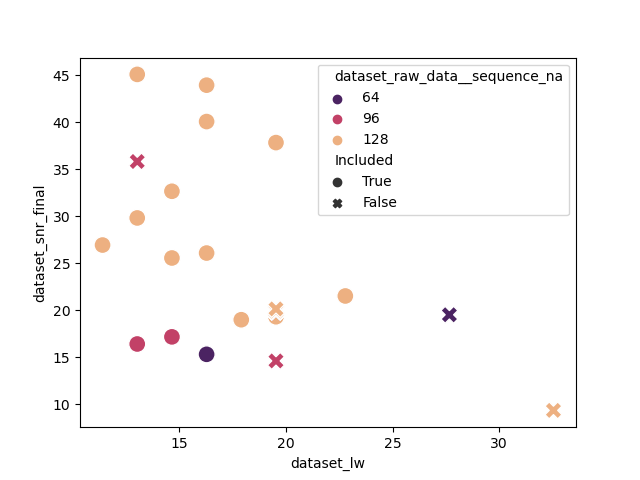

In [68]:
df_accepted = df_sc_final
df_rejected = df_sc_final_rej

df_accepted["Included"] = True
df_rejected["Included"] = False

this_df = pd.concat([df_accepted, df_rejected])

plt.figure()
g = sns.scatterplot(x="dataset_lw", y="dataset_snr_final",
                hue="dataset_raw_data__sequence_na", palette=cm,
                style="Included", style_order=[True, False],
                s=150, data=this_df)



In [69]:
df_rejected = df_sc_final_rej.drop_duplicates("patient_study_id")
g = sns.displot(df_rejected, x="dataset_raw_data__sequence_na")

<IPython.core.display.Javascript object>

About ideal scan time... It seems that NA >= 128 is really recommended. 50% of the subject we rejected from the study were acquired with NA < 128. It is a matter of SNR but also of accumulating scans over a long enough period of time and get the best out of it considering breathing etc.

Anyway more pretty to show that point? I don't think so. We will just mention the 50%, NA>=128 and therefore an effective scan time of 60/15bpm * 128 (1 cycle resp) = 8min to 16min (if 2 cycle worst case)

## P1 quantification boxplots and table

In [70]:
def run_p1_p2_stats_all_reco_types(this_df, threshold_snr, threshold_lw, threshold_fqn):

    # first, make the stats for P1
    df_filtered = this_df.loc[  (this_df["dataset_snr_final"] > threshold_snr) &
                                (this_df["dataset_lw"] < threshold_lw) &
                                (this_df["fit_results_optim_result_fqn"] < threshold_fqn)]
    
    df_filtered_rej = this_df.loc[  ((this_df["dataset_snr_final"] < threshold_snr) |
                                (this_df["dataset_lw"] > threshold_lw) |
                                (this_df["fit_results_optim_result_fqn"] > threshold_fqn))]

    # deal with orphans
    df_p1 = df_filtered.loc[(df_filtered["study"] == 1)]

    df_p2_orphan = df_filtered.loc[ (df_filtered["study"] == 2) &
                                    ~(df_filtered["patient"].isin(list(df_p1["patient"].unique()))) ]

    # changed to P1
    print("Number of P2 orphans fixed = %d" % len(df_p2_orphan["patient_study_id"].unique()))
    for this_index in list(df_p2_orphan.index):
        df_filtered.at[this_index, "study"] = 1
        df_filtered.at[this_index, "patient_study_id"] = df_filtered.at[this_index, "patient_study_id"] + "_orphan"

    
    # now deal with P1 stats only
    df_p1 = df_filtered.loc[(df_filtered["study"] == 1)]
        
    # txt output
    print("Number of P1 patients = %d" % len(df_p1["patient"].unique()))

    print("Metabolite".ljust(15) + " \t Area (SD) \t Fit (SD) \t raw CRB (med) \t ratio CRB (med) \t ratio CV (%)")
    for m in ["Cr_CH3", "Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:

        this_df_area = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "val")]

        this_df_fit_raw_err = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_obj") & 
                         (df_p1["param_p_val_type"] == "err")]  

        this_df_fit_ratio_err = df_p1.loc[(df_p1["param_m"] == m) &
                         (df_p1["param_p"] == "cm") &
                         (df_p1["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1["param_p_val_type"] == "err_prct")]  


        print("%s \t %.2f (%.2f) \t %.2f (%.2f) \t %06.2f \t\t %06.2f \t\t %06.2f" % 
              (m.ljust(15),
               this_df_area["param_val"].mean(),
               this_df_area["param_val"].std(),
               this_df_fit_ratio["param_val"].mean(),
               this_df_fit_ratio["param_val"].std(),
               this_df_fit_raw_err["param_val"].median(),
               this_df_fit_ratio_err["param_val"].median(),
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))

    # now deal with variability between P1 and P2
    df_p2 = df_filtered.loc[df_filtered["study"] == 2]

    df_p1 = df_filtered.loc[(df_filtered["patient"].isin(list(df_p2["patient"].unique()))) &
                            (df_filtered["study"] == 1)]

    df_p1_p2 = df_p1.append(df_p2)
    
    # txt output
    print()
    print("Number of P1 patients who did P2 = %d" % len(df_p1_p2["patient"].unique()))

    print("Metabolite".ljust(15) + "area CV (%) \t fit CV (%)")
    for m in ["Cr_CH3", "Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:
    
        this_df_area_ratio = df_p1_p2.loc[(df_p1_p2["param_m"] == m) &
                         (df_p1_p2["param_p"] == "cm") &
                         (df_p1_p2["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_p1_p2["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_p1_p2.loc[(df_p1_p2["param_m"] == m) &
                         (df_p1_p2["param_p"] == "cm") &
                         (df_p1_p2["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_p1_p2["param_p_val_type"] == "val")]

        print("%s %.2f \t\t %.2f" % 
              (m.ljust(15),
               this_df_area_ratio["param_val"].std() / this_df_area_ratio["param_val"].mean() * 100.0,
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))
        
    return(df_filtered, df_filtered_rej)

 

df, _ = run_p1_p2_stats_all_reco_types(df_sc, threshold_snr_final, threshold_lw_final, threshold_fqn_final)

Number of P2 orphans fixed = 2
Number of P1 patients = 12
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (med) 	 ratio CRB (med) 	 ratio CV (%)
Cr_CH3          	 1.00 (0.00) 	 1.00 (0.00) 	 001.87 		 000.00 		 000.00
Cho_CH3         	 0.29 (0.12) 	 0.31 (0.21) 	 000.75 		 011.85 		 066.28
NAA_CH3         	 1.39 (0.30) 	 1.50 (0.73) 	 002.13 		 008.52 		 048.51
Gln             	 0.00 (0.00) 	 1.44 (0.77) 	 010.13 		 023.34 		 053.60
Glu             	 0.00 (0.00) 	 3.17 (2.65) 	 014.71 		 023.01 		 083.55
mI              	 0.00 (0.00) 	 1.34 (0.76) 	 005.36 		 016.00 		 056.67
Tau             	 0.00 (0.00) 	 1.47 (1.81) 	 010.21 		 031.54 		 122.98

Number of P1 patients who did P2 = 4
Metabolite     area CV (%) 	 fit CV (%)
Cr_CH3          0.00 		 0.00
Cho_CH3         37.75 		 61.21
NAA_CH3         14.79 		 47.64
Gln             nan 		 70.16
Glu             nan 		 90.50
mI              nan 		 76.29
Tau             nan 		 84.35


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


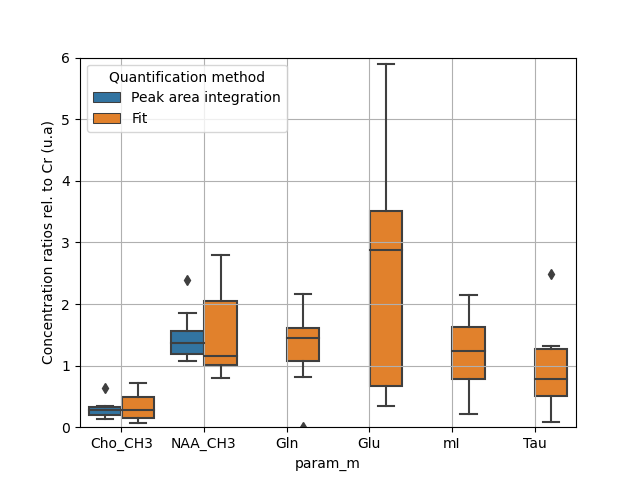

reco_type = optimal
n = 11
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (SD) 	 ratio CRB (SD) 	 ratio CV (%)
Cho_CH3         	 0.29 (0.14) 	 0.34 (0.23) 	 0.74 (0.24) 	 10.86 (5.26) 	 66.72
NAA_CH3         	 1.45 (0.39) 	 1.56 (0.72) 	 2.04 (0.28) 	 8.80 (4.20) 	 45.87
Gln             	 0.00 (0.00) 	 1.33 (0.61) 	 9.54 (3.30) 	 21.65 (3661.20) 	 45.55
Glu             	 0.00 (0.00) 	 2.49 (1.94) 	 12.69 (8.89) 	 23.62 (89.01) 	 77.62
mI              	 0.00 (0.00) 	 1.20 (0.62) 	 5.36 (3.64) 	 15.99 (24.23) 	 52.02
Tau             	 0.00 (0.00) 	 0.89 (0.68) 	 9.75 (6.76) 	 40.08 (101.35) 	 76.51


<IPython.core.display.Javascript object>

reco_type = no_data_rejection
n = 11
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (SD) 	 ratio CRB (SD) 	 ratio CV (%)
Cho_CH3         	 0.29 (0.12) 	 0.32 (0.22) 	 0.74 (0.20) 	 12.48 (6.41) 	 67.77
NAA_CH3         	 1.43 (0.31) 	 1.62 (0.87) 	 2.14 (0.35) 	 8.25 (4.60) 	 54.02
Gln             	 0.00 (0.00) 	 1.65 (0.79) 	 10.45 (3.86) 	 22.58 (106.96) 	 47.90
Glu             	 0.00 (0.00) 	 3.34 (2.65) 	 17.42 (17.04) 	 22.39 (68.58) 	 79.37
mI              	 0.00 (0.00) 	 1.38 (0.94) 	 5.68 (2.97) 	 17.37 (27.54) 	 68.02
Tau             	 0.00 (0.00) 	 2.23 (2.73) 	 11.11 (8.14) 	 23.98 (2986.84) 	 122.46


<IPython.core.display.Javascript object>


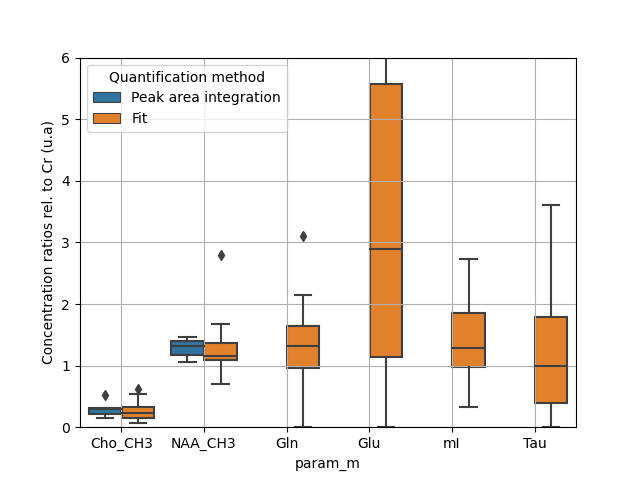

reco_type = no_data_rejection_no_realignement
n = 10
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (SD) 	 ratio CRB (SD) 	 ratio CV (%)
Cho_CH3         	 0.28 (0.10) 	 0.27 (0.18) 	 0.78 (0.22) 	 13.53 (6.20) 	 68.37
NAA_CH3         	 1.29 (0.14) 	 1.31 (0.59) 	 2.09 (0.42) 	 8.41 (4.31) 	 45.22
Gln             	 0.00 (0.00) 	 1.32 (0.92) 	 11.37 (4.27) 	 26.07 (4816.12) 	 70.28
Glu             	 0.00 (0.00) 	 3.74 (3.36) 	 17.57 (13.43) 	 19.81 (15829.24) 	 89.87
mI              	 0.00 (0.00) 	 1.45 (0.73) 	 5.72 (2.78) 	 14.04 (9.44) 	 50.47
Tau             	 0.00 (0.00) 	 1.27 (1.13) 	 11.43 (5.77) 	 35.23 (5244.05) 	 89.11


In [71]:

for this_reco_type in df["reco_type"].unique():

    df_filtered = df.loc[   (df["reco_type"] == this_reco_type) &
                            (df["study"] == 1)]

    metabolites_to_hide_list = ["Cho_CH2",
                                "Cr_CH3",
                                "Cr_CH2",
                                "NAA_CH2", 
                                "Lip1", "Lip2", "Water"]

    params_to_show_list = ['params_area_pnorm_T2norm_ratio_cre_obj', 
                           'params_fit_T2norm_ratio_cre_obj']

    # remove Pelayo because no REF scan, fucking up abs estimations!
    psid_to_hide_list = [] #["300_1"]

    this_df = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                                (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                                (df_filtered["param_p_val_type"] == "val") &
                                (df_filtered["param_m"].isin(["Cho_CH3", "NAA_CH3"]))
                                ]

    this_df2 = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                        (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                        (df_filtered["param_p_val_type"] == "val") &
                        ~(df_filtered["param_m"].isin(metabolites_to_hide_list))]

    this_df = this_df.append(this_df2)
    this_df["param_p_type"] = this_df["param_p_type"].str.replace("params_area_pnorm_T2norm_ratio_cre_obj", "Peak area integration")
    this_df["param_p_type"] = this_df["param_p_type"].str.replace("params_fit_T2norm_ratio_cre_obj", "Fit")
    this_df = this_df.rename(columns = {'param_p_type':'Quantification method'})

    plt.figure()
    g = sns.boxplot(x="param_m", y="param_val", hue="Quantification method", data=this_df)
    plt.ylabel("Concentration ratios rel. to Cr (u.a)")
    plt.grid('on')
    plt.ylim([0, 6])

    # txt output
    print("reco_type = %s" % this_reco_type)
    print("n = %d" % len(df_filtered["patient_study_id"].unique()))

    print("Metabolite".ljust(15) + " \t Area (SD) \t Fit (SD) \t raw CRB (SD) \t ratio CRB (SD) \t ratio CV (%)")
    for m in ["Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:

        this_df_area = df_filtered.loc[(df_filtered["param_m"] == m) &
                         (df_filtered["param_p"] == "cm") &
                         (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_filtered["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_filtered.loc[(df_filtered["param_m"] == m) &
                         (df_filtered["param_p"] == "cm") &
                         (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_filtered["param_p_val_type"] == "val")]

        this_df_fit_raw_err = df_filtered.loc[(df_filtered["param_m"] == m) &
                         (df_filtered["param_p"] == "cm") &
                         (df_filtered["param_p_type"] == "params_fit_obj") & 
                         (df_filtered["param_p_val_type"] == "err")]  

        this_df_fit_ratio_err = df_filtered.loc[(df_filtered["param_m"] == m) &
                         (df_filtered["param_p"] == "cm") &
                         (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_filtered["param_p_val_type"] == "err_prct")]  


        print("%s \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f" % 
              (m.ljust(15),
               this_df_area["param_val"].mean(),
               this_df_area["param_val"].std(),
               this_df_fit_ratio["param_val"].mean(),
               this_df_fit_ratio["param_val"].std(),
               this_df_fit_raw_err["param_val"].mean(),
               this_df_fit_raw_err["param_val"].std(),
               this_df_fit_ratio_err["param_val"].median(),
               this_df_fit_ratio_err["param_val"].std(),
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))


## P1 vs. P2 quantification boxplots

<IPython.core.display.Javascript object>

reco_type = optimal
n = 4
Metabolite     area CV (%) 	 fit CV (%)
Cho_CH3         42.49 	 66.91
NAA_CH3         16.58 	 42.69
Gln             nan 	 54.99
Glu             nan 	 80.85
mI              nan 	 64.78
Tau             nan 	 73.59


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


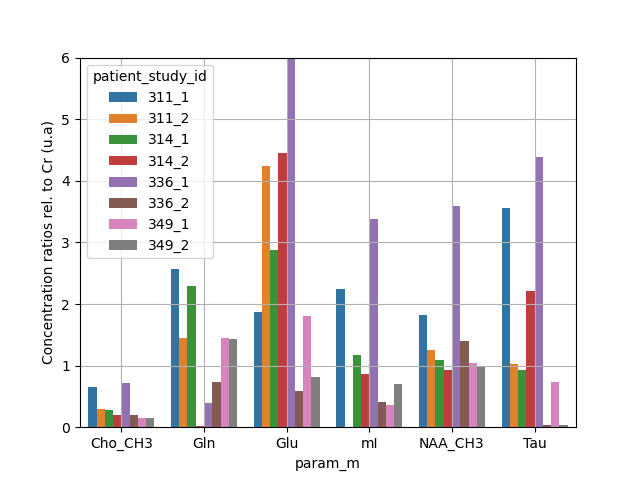

reco_type = no_data_rejection
n = 4
Metabolite     area CV (%) 	 fit CV (%)
Cho_CH3         39.07 	 68.85
NAA_CH3         17.66 	 58.89
Gln             nan 	 68.21
Glu             nan 	 86.43
mI              nan 	 98.95
Tau             nan 	 100.77


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>

reco_type = no_data_rejection_no_realignement
n = 3
Metabolite     area CV (%) 	 fit CV (%)
Cho_CH3         36.10 	 54.00
NAA_CH3         8.76 	 43.95
Gln             nan 	 105.83
Glu             nan 	 110.00
mI              nan 	 71.56
Tau             nan 	 52.96


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


In [72]:
for this_reco_type in df["reco_type"].unique():

    df_p2 = df.loc[   (df["reco_type"] == this_reco_type) &
                            (df["study"] == 2)]

    df_p1 = df.loc[   (df["reco_type"] == this_reco_type) &
                            (df["patient"].isin(list(df_p2["patient"].unique()))) &
                           (df["study"] == 1)]

    df_filtered = df_p1.append(df_p2)

    metabolites_to_hide_list = ["Cho_CH2",
                                "Cr_CH3",
                                "Cr_CH2",
                                "NAA_CH2", 
                                "Lip1", "Lip2", "Water"]

    this_df = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                        (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                        (df_filtered["param_p_val_type"] == "val") &
                        ~(df_filtered["param_m"].isin(metabolites_to_hide_list))]

    plt.figure()
    g = sns.barplot(x="param_m", y="param_val", hue="patient_study_id", data=this_df,
                   hue_order=list(df_filtered["patient_study_id"].sort_values().unique()))
    plt.ylabel("Concentration ratios rel. to Cr (u.a)")
    plt.grid('on')
    plt.ylim([0, 6])

    # txt output
    print("reco_type = %s" % this_reco_type)
    print("n = %d" % len(df_filtered["patient"].unique()))

    print("Metabolite".ljust(15) + "area CV (%) \t fit CV (%)")
    for m in ["Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:

        this_df_area_ratio = df_filtered.loc[(df_filtered["param_m"] == m) &
                         (df_filtered["param_p"] == "cm") &
                         (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                         (df_filtered["param_p_val_type"] == "val")]

        this_df_fit_ratio = df_filtered.loc[(df_filtered["param_m"] == m) &
                         (df_filtered["param_p"] == "cm") &
                         (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                         (df_filtered["param_p_val_type"] == "val")]

        print("%s %.2f \t %.2f" % 
              (m.ljust(15),
               this_df_area_ratio["param_val"].std() / this_df_area_ratio["param_val"].mean() * 100.0,
               this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))
